In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import plot_tree
import catboost as cb
from matplotlib.gridspec import GridSpec
from numpy import pi
from scipy.stats import shapiro
from scipy import stats
import scipy.stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
plt.rcParams["axes.unicode_minus"]=False

# 배경 및 목표
## 2020년 뉴스
- 스마트팩토리 포스코 광양제철소 후판공장 불량품 재처리 비용 30% 줄여
    - 리얼 타임 데이터 분석 방법을 도입해 원인을 정확히 파악해 문제점을 제거한다. 
    
## 분석 목표
- 00 공장 고객사에서 최근 들어 스케일 불량 발생 증가라는 이슈가 발생했다. 그 원인을 분석해본 결과, 압연공정에서 scale 불량이 급증한 것을 알 수 있엇다. 수집한 여러 공정 데이터를 바탕으로 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 결과를 해석해 개선 기회를 도출한다. 
- 불량 원인을 찾아 개선한다면, 생산성 증대를 통해 수익이 증가하고, 고객의 신뢰를 높이고, '스마트팩토리'로서 대외 이미지를 구축할 수 있을 것이다.

- 실제 포스코에서 지적한 스케일 불량 발생 인자들과 예측 모델이 뽑은 주요 인자가 얼마나 일치하는지 보고 싶다.
    - 포스코 특허 번호 10-1428320에서 
    - 주요인자: 가열시간(FUR_TIME), 추출온도(FUR_EXTEMP), 디스켈링횟수(ROLLING_DESCALING) 등이 내가 만든 모델의 주요인자로 들어있는지 확인하도록 한다

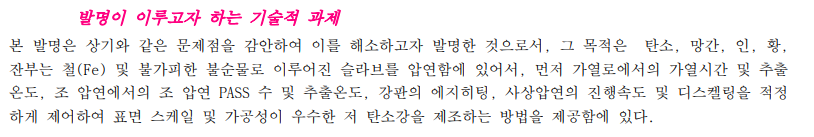

# 목표변수/설명변수

In [2]:
raw_data=pd.read_csv("./SCALE불량.csv", encoding='euc-kr')
raw_data.drop(["PLATE_NO", "ROLLING_DATE"], axis=1, inplace=True)
raw_data.head()
# 목표변수 SCALE을 1 불량 0 양품 으로 변경해준다

raw_data['SCALE']=[1 if (s =='불량') else 0 for s in raw_data['SCALE']]
raw_data.head(5)

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1125,934,적용,8,2조
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1120,937,적용,8,2조
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1106,889,적용,8,3조
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1113,885,적용,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1118,873,적용,8,1조


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              720 non-null    int64  
 1   SPEC               720 non-null    object 
 2   STEEL_KIND         720 non-null    object 
 3   PT_THK             720 non-null    float64
 4   PT_WDTH            720 non-null    int64  
 5   PT_LTH             720 non-null    int64  
 6   PT_WGT             720 non-null    int64  
 7   FUR_NO             720 non-null    object 
 8   FUR_NO_ROW         720 non-null    int64  
 9   FUR_HZ_TEMP        720 non-null    int64  
 10  FUR_HZ_TIME        720 non-null    int64  
 11  FUR_SZ_TEMP        720 non-null    int64  
 12  FUR_SZ_TIME        720 non-null    int64  
 13  FUR_TIME           720 non-null    int64  
 14  FUR_EXTEMP         720 non-null    int64  
 15  ROLLING_TEMP_T5    720 non-null    int64  
 16  HSB                720 non

- 총 21개 컬럼
    - scale : 목표변수 1-불량, 0-정상
    - 20개 이외의 설명변수들(추후에 삭제되거나 추가될 수 있음)

In [4]:
raw_data.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.320833,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.204167,1149.666667,75.330556,300.563889,1139.570833,933.920833,8.319444
std,0.467121,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,36.248696,17.571788,26.086390,45.390303,17.857121,107.863887,1.623252
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1102.000000,0.000000,5.000000
25%,0.000000,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1122.750000,889.750000,6.000000
50%,0.000000,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1144.000000,951.000000,8.000000
75%,1.000000,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,85.250000,342.000000,1154.000000,994.250000,10.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,251.000000,1185.000000,194.000000,398.000000,1175.000000,1078.000000,10.000000


# 데이터 전처리

## 데이터 중복 확인 및 결측치 확인

In [5]:
print("**중복 데이터** {}".format(raw_data.duplicated().sum()))
print("**결측치 확인** \n{}".format(raw_data.isnull().sum()))

**중복 데이터** 0
**결측치 확인** 
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64


- 중복 데이터가 없고, 결측치가 없음을 확인함

## 이상치 확인
- 연속형 설명변수들에 한해 이상치를 확인해본다

In [6]:
data_continu=raw_data.select_dtypes(exclude='object')
data_continu.head(3)

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,0,32.25,3707,15109,14180,1,1144,116,1133,59,282,1125,934,8
1,0,32.25,3707,15109,14180,2,1144,122,1135,53,283,1120,937,8
2,0,33.27,3619,19181,18130,1,1129,116,1121,55,282,1106,889,8


In [7]:
# 연속형 변수 개수
len(data_continu.columns)

14

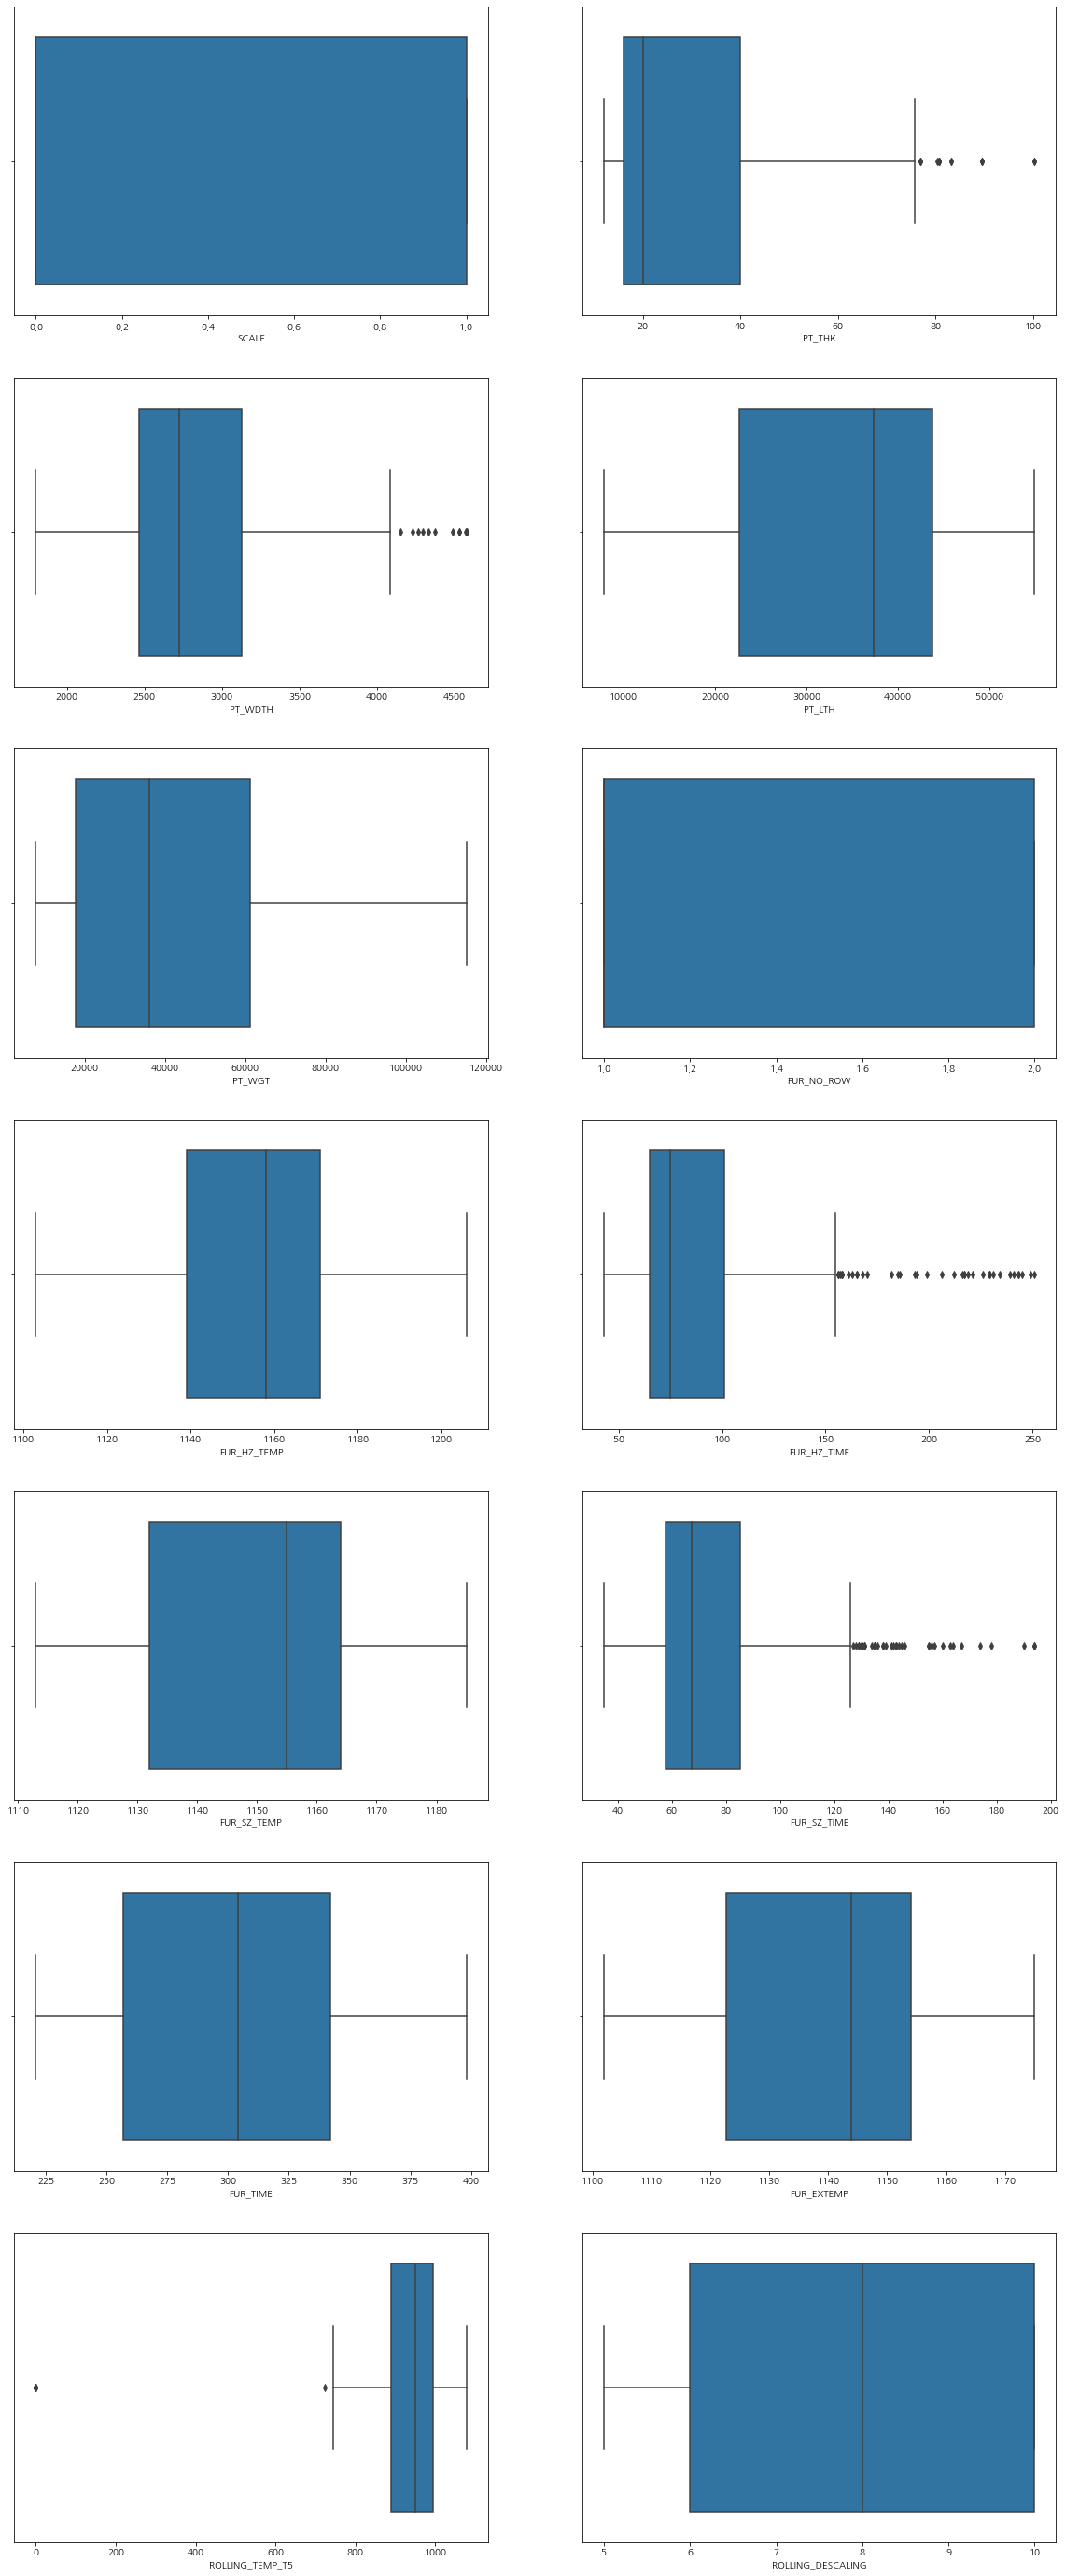

In [8]:


fig, ax = plt.subplots(figsize=(20, 50), nrows=7, ncols=2)
k=0

for i in range(7):
    for j in range(2):
        sns.boxplot(x=data_continu.iloc[:, k], orient='h', ax=ax[i,j])
        k+=1

## 불량 발생률
- 전체 작업 중 불량은 얼마나 발생했는가?

In [9]:
print("전체 데이터 중 불량 발생률: {:.3f}".format(raw_data['SCALE'].mean()))

전체 데이터 중 불량 발생률: 0.321


## 작업조 별 불량률
- WORK_GR 별 SCALE 발생률

In [10]:
gr_scale=raw_data.groupby(['WORK_GR'], as_index=False).mean().loc[:, ['WORK_GR', 'SCALE']]
gr_scale

,WORK_GR,SCALE
0,1조,0.354497
1,2조,0.272727
2,3조,0.313953
3,4조,0.335052


<BarContainer object of 4 artists>

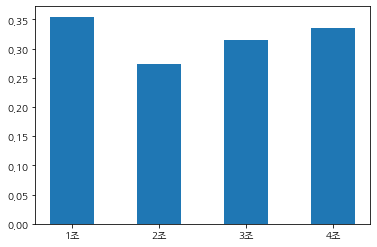

In [11]:
labels=gr_scale['WORK_GR']

plt.bar(labels, gr_scale['SCALE'], width=0.5)

- 작업그룹 1조는 스케일 불량률을 35%로 가장 높은 불량률을 기록했다.

## 호기별 불량률

  FUR_NO     SCALE
0    1호기  0.304167
1    2호기  0.295359
2    3호기  0.362140


<BarContainer object of 3 artists>

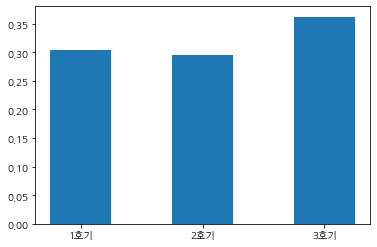

In [12]:
gr_scale=raw_data.groupby(['FUR_NO'], as_index=False).mean().loc[:, ['FUR_NO', 'SCALE']]
print(gr_scale)
labels=gr_scale['FUR_NO']

plt.bar(labels, gr_scale['SCALE'], width=0.5)

- 3호기가 작업 중 스케일 불량을 36% 기록해 호기별 가장 높은 불량률을 보였다

## 변수들 간 관계 확인

In [13]:
corr=raw_data.corr().round(3)
corr

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,1.000,-0.125,-0.206,0.100,0.219,-0.023,0.248,0.064,0.375,-0.255,-0.049,0.375,0.385,-0.007
PT_THK,-0.125,1.000,-0.313,-0.863,-0.397,-0.003,-0.524,0.172,-0.695,0.269,0.413,-0.688,-0.374,-0.837
PT_WDTH,-0.206,-0.313,1.000,0.120,0.031,0.007,0.180,-0.126,0.227,-0.051,-0.393,0.216,-0.022,0.338
PT_LTH,0.100,-0.863,0.120,1.000,0.452,-0.021,0.473,-0.090,0.645,-0.230,-0.252,0.641,0.313,0.809
PT_WGT,0.219,-0.397,0.031,0.452,1.000,-0.022,0.153,0.007,0.360,-0.193,-0.058,0.361,0.263,0.239
FUR_NO_ROW,-0.023,-0.003,0.007,-0.021,-0.022,1.000,0.005,-0.008,0.009,0.062,0.016,0.014,-0.004,0.018
FUR_HZ_TEMP,0.248,-0.524,0.180,0.473,0.153,0.005,1.000,-0.112,0.773,-0.328,-0.348,0.758,0.265,0.471
FUR_HZ_TIME,0.064,0.172,-0.126,-0.090,0.007,-0.008,-0.112,1.000,-0.210,0.068,0.483,-0.196,0.010,-0.152
FUR_SZ_TEMP,0.375,-0.695,0.227,0.645,0.360,0.009,0.773,-0.210,1.000,-0.566,-0.477,0.985,0.452,0.649
FUR_SZ_TIME,-0.255,0.269,-0.051,-0.230,-0.193,0.062,-0.328,0.068,-0.566,1.000,0.491,-0.566,-0.269,-0.286


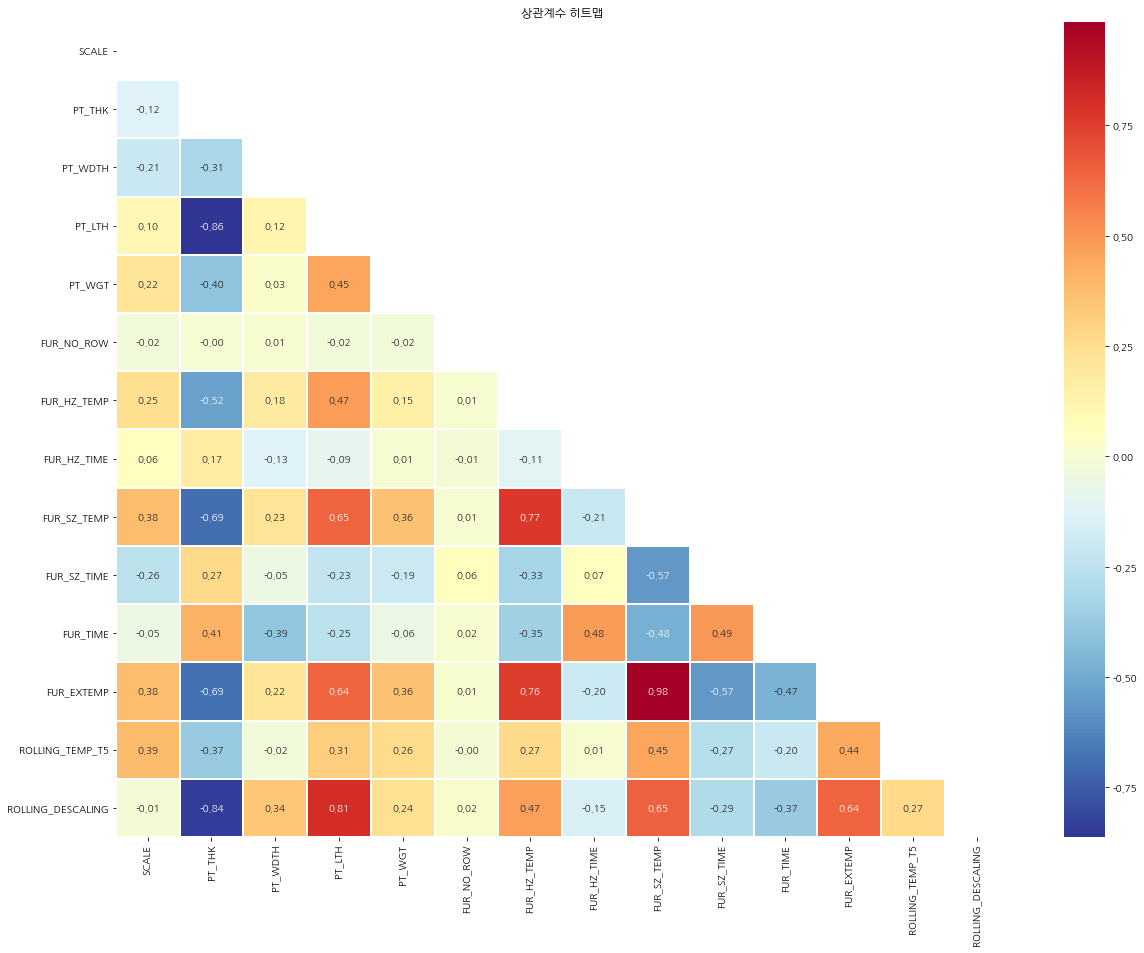

In [14]:
plt.figure(figsize = (20, 15))

# 히트맵 형태 정의. 여기서는 삼각형 형태(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
sns.heatmap(data = corr,    # 'corr' = 상관계수 테이블
            annot = True,  # 히트맵에 값 표시
            mask=mask,   # 히트맵 형태. 여기서는 위에서 정의한 삼각형 형태
            fmt = '.2f',   # 값 표시 방식. 소숫점 2번째자리까지 
            linewidths = 1.,  # 경계면 실선 구분 여부
            cmap = 'RdYlBu_r')  # 사용할 색 지정 ('python colormap 검색')
plt.title('상관계수 히트맵')
plt.show()

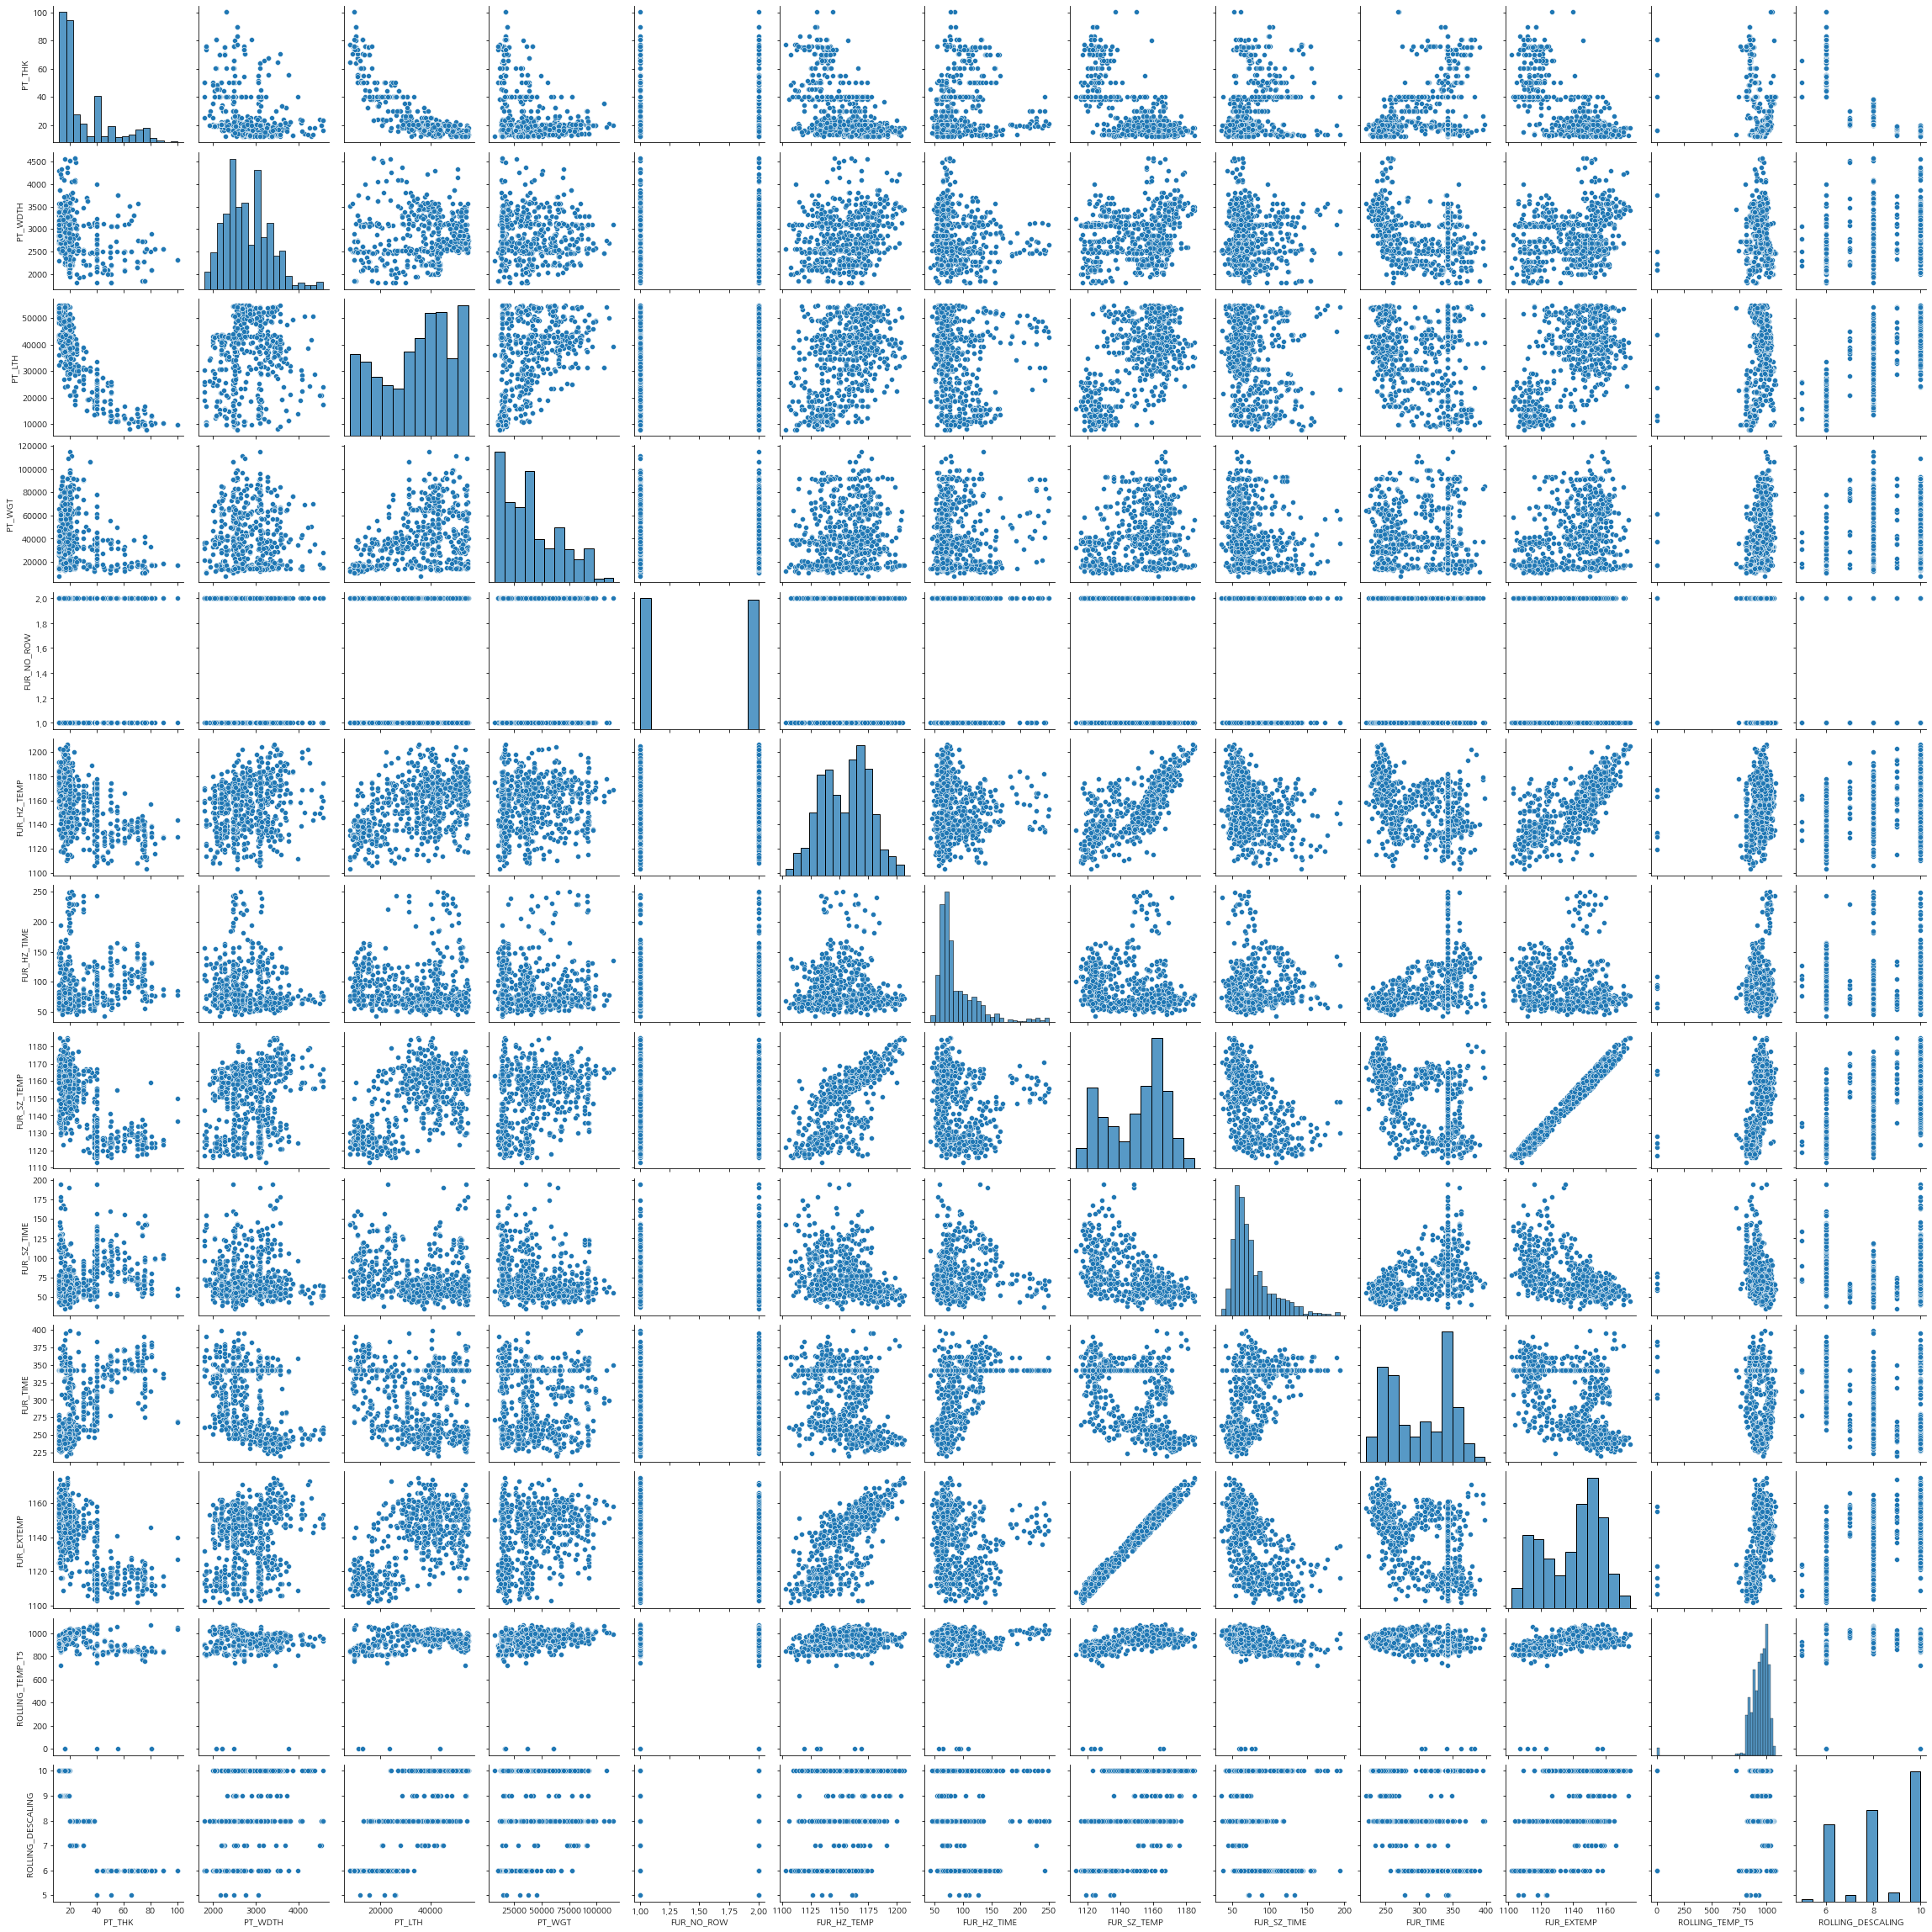

In [15]:
without_scale_data_continu=data_continu.drop('SCALE', axis=1)
sns.pairplot(without_scale_data_continu)

In [16]:
absedcorr=abs(corr)
corr_count=0
for i in range(1, len(absedcorr)):
    for j in range(i):
        if absedcorr.iloc[j][i]>0.8:
            print("Corr btw {} and {} : {}".format(absedcorr.index[j], absedcorr.index[i],absedcorr.iloc[j][i] ))
            corr_count+=1
print("\n\n****0.8 이상의 상관계수를 갖는 변수 쌍의 개수**** \n\t\t\t{}쌍".format(corr_count))

Corr btw PT_THK and PT_LTH : 0.863
Corr btw FUR_SZ_TEMP and FUR_EXTEMP : 0.985
Corr btw PT_THK and ROLLING_DESCALING : 0.837
Corr btw PT_LTH and ROLLING_DESCALING : 0.809


****0.8 이상의 상관계수를 갖는 변수 쌍의 개수**** 
			4쌍


- 강한 상관관계에 있는 4쌍의 변수들을 정리해준다.
- ROLLING_DESCALING와 FUR_SZ_TEMP만 남기고 삭제해준다.

In [17]:
abs(corr['SCALE']).sort_values(ascending=False)

SCALE                1.000
ROLLING_TEMP_T5      0.385
FUR_EXTEMP           0.375
FUR_SZ_TEMP          0.375
FUR_SZ_TIME          0.255
FUR_HZ_TEMP          0.248
PT_WGT               0.219
PT_WDTH              0.206
PT_THK               0.125
PT_LTH               0.100
FUR_HZ_TIME          0.064
FUR_TIME             0.049
FUR_NO_ROW           0.023
ROLLING_DESCALING    0.007
Name: SCALE, dtype: float64

- scale과 설명변수간 correlation

## SPEC 컬럼을 제품 규격별로 새로 설정
- 60여개가 넘는 유니크한 스펙 데이터를 정제해본다
- 규격은 포스코 사에서 정한대로 'POSCO, KS, JIS, ASTM, 기타'로 분리될 수 있다.
    - POSCO : PILAC, POSTEM 등
    - KS : KS D, SS 등
    - JIS : JIS, SM, NK 등
    - ASTM : EH32 등
    - 기타 : BV, LR, EH36 등으로 정리될 수 있음

In [18]:
print(raw_data['SPEC'].value_counts())

JS-SM490YB    84
LR-A          54
NV-A          48
PILAC-BT33    40
BV-EH36-TM    35
              ..
BV-EH32-TM     1
BV-AH36-TM     1
BV-A           1
KR-B           1
CCS-B          1
Name: SPEC, Length: 66, dtype: int64


- 제품 규격은 총 66 종류이고, 그 중 JS-SM490YB 규격이 총  720개 샘플 중 84개를 차지한다.

In [19]:
raw_data['SPEC'].unique()

array(['AB/EH32-TM', 'NV-E36-TM', 'BV-EH36-TM', 'COMMON', 'GL-E32-TM',
       'GL-E36-TM', 'AB/EH36-TM', 'KS-HSB600', 'LR-EH36-TM', 'BV-B',
       'LR-B', 'JS-SM490YB', 'KR-B', 'LR-A', 'JS-SM490A', 'KS-SM400B',
       'JS-SM400B', 'AB/B', 'KS-SS400', 'KR-A', 'NV-A', 'JS-SS400',
       'KS-SM400A', 'KS-SM490B', 'V42JBN3', 'BV-AH32', 'JS-SM490YA',
       'AB/AH32', 'LR-AH32', 'NV-B', 'NV-A32', 'KS-SM490A', 'NK-KA32',
       'GL-A32', 'AB/A', 'LR-AH36', 'A709-36', 'KR-AH32', 'A516-60',
       'GL-A', 'NK-KA', 'NV-D36-TM', 'NK-KA32-TM', 'GL-A32-TM',
       'LR-AH36-TM', 'LR-EH32-TM', 'NV-E32-TM', 'KS-HSB500', 'API-2W-50T',
       'GL-A36-TM', 'BV-EH32-TM', 'NV-A32-TM', 'NV-D32-TM', 'NK-KD36-TM',
       'GL-D36-TM', 'PILAC-BT33', 'BV-AH32-TM', 'BV-AH36-TM', 'NV-A36-TM',
       'A131-DH36TM', 'BV-AH36-TL', 'BV-A', 'CCS-B', 'A283-C', 'SA283-C',
       'JS-SM400A'], dtype=object)

In [20]:
raw_data.loc[raw_data['SPEC'].str.startswith('API'), 'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('KS')|raw_data['SPEC'].str.startswith('KR'), 'SPEC']='KS'
raw_data.loc[raw_data['SPEC'].str.startswith('NV'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('BV'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('GL'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('JS')|raw_data['SPEC'].str.startswith('NK')|raw_data['SPEC'].str.endswith('SS490'),'SPEC']='JIS'
raw_data.loc[raw_data['SPEC'].str.startswith('GL')|raw_data['SPEC'].str.startswith('V4'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('PILAC'),'SPEC']='POSCO'
raw_data.loc[raw_data['SPEC'].str.startswith('COMMON')|raw_data['SPEC'].str.endswith('DH36TM'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('LR')|raw_data['SPEC'].str.startswith('CCS'),'SPEC']='기타'
raw_data.loc[raw_data['SPEC'].str.startswith('AB') | raw_data['SPEC'].str.startswith('SA')|raw_data['SPEC'].str.startswith('A516')|raw_data['SPEC'].str.startswith('A709')|raw_data['SPEC'].str.startswith('A283'),'SPEC']='ASTM'

In [21]:
print(raw_data['SPEC'].value_counts())

기타       388
JIS      166
ASTM      67
KS        59
POSCO     40
Name: SPEC, dtype: int64


In [22]:
raw_data

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,ASTM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1125,934,적용,8,2조
1,0,ASTM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1120,937,적용,8,2조
2,0,기타,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1106,889,적용,8,3조
3,0,기타,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1113,885,적용,8,3조
4,0,기타,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1118,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,JIS,C0,20.14,3580,38639,21870,3호기,1,1172,72,1164,62,245,1155,1005,적용,8,2조
716,0,기타,C0,15.08,3212,48233,18340,2호기,1,1150,61,1169,61,238,1160,947,적용,10,1조
717,0,기타,C0,16.60,3441,43688,19590,2호기,2,1169,65,1163,77,247,1152,948,적용,10,4조
718,0,기타,C0,15.59,3363,48740,80240,3호기,2,1179,86,1163,45,243,1154,940,적용,10,2조


### 선형 관계 변수

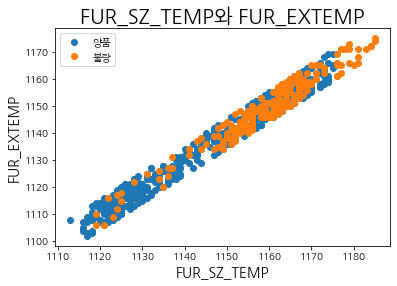

In [23]:
groups=raw_data.groupby('SCALE')
fig, ax=plt.subplots()

for name, data in groups:
    ax.plot(data.FUR_SZ_TEMP, data.FUR_EXTEMP, label=name, marker='o', linestyle='')
    ax.legend(fontsize=12, loc='upper left') # legend position

plt.title('FUR_SZ_TEMP와 FUR_EXTEMP', fontsize=20)
plt.legend(['양품', '불량'])
plt.xlabel('FUR_SZ_TEMP', fontsize=14)

plt.ylabel('FUR_EXTEMP', fontsize=14)

plt.show()


- FUR_SZ_TEMP와 FUR_EXTEMP는 완벽한 선형관계를 보이고 있다
- 둘의 correlation을 확인하도록 한다

In [24]:
abs(corr['FUR_EXTEMP']).sort_values(ascending=False)

FUR_EXTEMP           1.000
FUR_SZ_TEMP          0.985
FUR_HZ_TEMP          0.758
PT_THK               0.688
ROLLING_DESCALING    0.642
PT_LTH               0.641
FUR_SZ_TIME          0.566
FUR_TIME             0.468
ROLLING_TEMP_T5      0.441
SCALE                0.375
PT_WGT               0.361
PT_WDTH              0.216
FUR_HZ_TIME          0.196
FUR_NO_ROW           0.014
Name: FUR_EXTEMP, dtype: float64

- FUR_EXTEMP와 FUR_SZ_TEMP는 0.985의 상관계수를 가진다.
- 따라서 둘 중 하나인 FUR_EXTEMP를 삭제한다
- 위에서 언급한 다른 강한 상관관계인 변수 PT_THK and PT_LTH를 삭제한다

In [25]:
raw_data.drop('FUR_EXTEMP', axis=1, inplace=True)

In [26]:
raw_data.drop(['PT_THK','PT_LTH'], axis=1, inplace=True)

In [27]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SCALE              720 non-null    int64 
 1   SPEC               720 non-null    object
 2   STEEL_KIND         720 non-null    object
 3   PT_WDTH            720 non-null    int64 
 4   PT_WGT             720 non-null    int64 
 5   FUR_NO             720 non-null    object
 6   FUR_NO_ROW         720 non-null    int64 
 7   FUR_HZ_TEMP        720 non-null    int64 
 8   FUR_HZ_TIME        720 non-null    int64 
 9   FUR_SZ_TEMP        720 non-null    int64 
 10  FUR_SZ_TIME        720 non-null    int64 
 11  FUR_TIME           720 non-null    int64 
 12  ROLLING_TEMP_T5    720 non-null    int64 
 13  HSB                720 non-null    object
 14  ROLLING_DESCALING  720 non-null    int64 
 15  WORK_GR            720 non-null    object
dtypes: int64(11), object(5)
memory usage: 90.1+ 

# 기술적 분석

- 각 분석 모델별 트레인 데이터 정확도와 테스트 데이터 정확도를 저장할 수 있도록 한다

    - 로지스틱 회귀분석
    - SVC
    - DT
    - RandomForest
    - GradientBoosting
    - Catboost



In [28]:
# 정확도 저장용 리스트
final_model_acc=['Logistic', "SVC", "DT", "RandomForest","GradientBoosting", "Catboost"]
final_train_accuracy=[]
final_test_accuracy=[]
final_model_f1_score=[]

## 로지스틱 -unscaled
### 가설 선정
- h0(귀무가설):모든 변수들의 회귀계수는 0이다(설명력이 없다)
- h1(대립가설):회귀계수가 0 이 아닌 변수가 적어도 하나 존재한다 (설명력이 있다)
### 데이터 분할

In [29]:
# C1 하나를 C0로 변경한다
raw_data.loc[raw_data['STEEL_KIND'].str.startswith('C1'), 'STEEL_KIND']='C0'

df_logi_train, df_logi_test=train_test_split(raw_data, test_size=0.3, random_state=1234)
print('train size: {}'.format(df_logi_train.shape))
print('test size: {}'.format(df_logi_test.shape))

raw_data.columns

train size: (504, 16)
test size: (216, 16)


Index(['SCALE', 'SPEC', 'STEEL_KIND', 'PT_WDTH', 'PT_WGT', 'FUR_NO',
       'FUR_NO_ROW', 'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP',
       'FUR_SZ_TIME', 'FUR_TIME', 'ROLLING_TEMP_T5', 'HSB',
       'ROLLING_DESCALING', 'WORK_GR'],
      dtype='object')

### 모델 변수 설정

In [30]:
log_model=Logit.from_formula("""SCALE ~ C(SPEC)+ C(STEEL_KIND)+
PT_WDTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+
FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+ROLLING_TEMP_T5+C(HSB)+ROLLING_DESCALING+C(WORK_GR)""", df_logi_train)

In [31]:
df_logi_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 95 to 294
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SCALE              504 non-null    int64 
 1   SPEC               504 non-null    object
 2   STEEL_KIND         504 non-null    object
 3   PT_WDTH            504 non-null    int64 
 4   PT_WGT             504 non-null    int64 
 5   FUR_NO             504 non-null    object
 6   FUR_NO_ROW         504 non-null    int64 
 7   FUR_HZ_TEMP        504 non-null    int64 
 8   FUR_HZ_TIME        504 non-null    int64 
 9   FUR_SZ_TEMP        504 non-null    int64 
 10  FUR_SZ_TIME        504 non-null    int64 
 11  FUR_TIME           504 non-null    int64 
 12  ROLLING_TEMP_T5    504 non-null    int64 
 13  HSB                504 non-null    object
 14  ROLLING_DESCALING  504 non-null    int64 
 15  WORK_GR            504 non-null    object
dtypes: int64(11), object(5)
memory usage: 66.9+

### 훈련

In [32]:
log_result=log_model.fit(method='bfgs')

         Current function value: 0.271601
         Iterations: 35
         Function evaluations: 50
         Gradient evaluations: 39


C:\Users\h\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\h\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\h\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\h\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\h\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##  회귀계수 검토

In [33]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      476
Method:                           MLE   Df Model:                           27
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.5654
Time:                        19:54:54   Log-Likelihood:                -136.89
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 3.896e-59
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3068     24.918     -0.012      0.990     -49.144      48.531
C(SPEC)[T.JIS]          0.6545      0.575      1.139      0.255      -0.472       1.781
C(SPEC)[T.KS]   

- 전체 자료 수 : 504개(트레인 데이터)
- 설명력 : 0.5654
- 회귀계수 검정 
    - 유의수준 0.05에서 유의한 변수
        - SPEC 카테고리 안 변수들은 모두 p value가 0.05 이상이므로 해당 카테고리 안에서 유의미하다고 할 수 없다
        - p value가 0.05보다 작은 변수들은 해당 모델에서 유의미하다고 할 수 있다.
        - 귀무가설 '모든 변수들의 회귀계수는 0이다(설명력이 없다)'는 지지되지 못한다. 
        - 회귀계수가 0 이 아닌 변수가 적어도 하나 존재한다 (설명력이 있다)인 대립가설이 채택된다.
        - 따라서 입력된 변수들 중 적어도 하나 이상은 모델의 설명력을 가지고 있다고 말할 수 있다
        
            - FUR_HZ_TEMP,ROLLING_DESCALING, ROLLING_TEMP_T5, FUR_SZ_TEMP 

## 예측 및 성능평가

In [34]:
#0.5를 임계치로 해 1 -> 불량 0 -> 양품 진단
train_y_pred = log_result.predict(df_logi_train)
train_y_pred_class = (train_y_pred > 0.5).astype(int)
log_train_acc = accuracy_score(df_logi_train["SCALE"], train_y_pred_class)

y_pred = log_result.predict(df_logi_test)
y_pred_class = (y_pred > 0.5).astype(int)
log_test_pred_acc = accuracy_score(df_logi_test["SCALE"], y_pred_class)
y_pred_class.head()
print("트레이닝 데이터에 대한 정확도: {:.3f}".format(log_train_acc))
print("테스트데이터에 대한 정확도: {:.3f}".format(log_test_pred_acc))
log_f1_score = f1_score(df_logi_test["SCALE"], y_pred_class)
print("F1 score: {:.3f}".format(log_f1_score))


트레이닝 데이터에 대한 정확도: 0.895
테스트데이터에 대한 정확도: 0.856
F1 score: 0.792


In [35]:

log_test_pred_acc = accuracy_score(df_logi_test["SCALE"], y_pred_class)
print('***Confusion Matrix***\n{}\n'.format(confusion_matrix(df_logi_test['SCALE'], y_pred_class)))
print("\t\t  ***Classification Report***\n{}".format(classification_report(df_logi_test['SCALE'], y_pred_class, digits=2)))


***Confusion Matrix***
[[126  19]
 [ 12  59]]

		  ***Classification Report***
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       145
           1       0.76      0.83      0.79        71

    accuracy                           0.86       216
   macro avg       0.83      0.85      0.84       216
weighted avg       0.86      0.86      0.86       216



- 실제 양품을 양픔으로 분류한 것은 126건
- 실제 불량을 양품으로 잘못 분류한 것은 12건
- 불량을 기준으로 f1 score는 약 80%이다

## 결론도출

<AxesSubplot:>

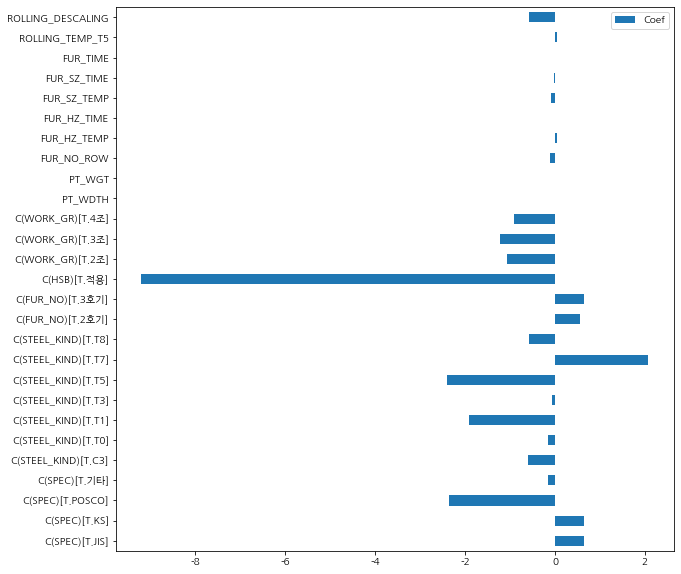

In [36]:
ds_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])
ds_logistic_coef.plot.barh(y = "Coef", figsize = (10, 10))

- 인자별 중요도를 뽑아보았다. 
    - HSB가 적용되면, 불량일 가능성이 낮아진다.
    - 강종 종류 중 T5, T1이면 불량일 가능성이 낮아진다. 
    - 강종 종류 중 T7이면 불량일 가능성이 커진다.
    - 제품규격이 POSCO에 해당할수록 불량일 가능성이 낮아진다.

## 로지스틱 -scaled

In [37]:

raw_data_x=raw_data.iloc[:,0 ]
raw_data_x

0      0
1      0
2      0
3      0
4      0
      ..
715    1
716    0
717    0
718    0
719    0
Name: SCALE, Length: 720, dtype: int64

In [38]:
df_char=raw_data.select_dtypes(include="object")
df_numeric=raw_data.select_dtypes(exclude="object")

# scaling
scaler=StandardScaler()
np_numeric_scaled=scaler.fit_transform(df_numeric)
df_numeric_sclaed=pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

df_scaled=pd.concat([df_numeric_sclaed, df_char], axis=1)
df_scaled['SCALE']=raw_data_x

df_scaled

,SCALE,PT_WDTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,SPEC,STEEL_KIND,FUR_NO,HSB,WORK_GR
0,0,1.738951,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,0.000734,-0.196930,ASTM,T1,1호기,적용,2조
1,0,1.738951,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,0.028567,-0.196930,ASTM,T1,1호기,적용,2조
2,0,1.568896,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-0.416748,-0.196930,기타,T8,2호기,적용,3조
3,0,1.568896,-0.944112,1.005571,-0.160124,1.015800,-1.290843,-0.281206,0.340311,-0.453858,-0.196930,기타,T8,2호기,적용,3조
4,0,0.562094,-1.174562,-0.994460,-0.735611,1.264257,-1.233894,-1.048422,0.296219,-0.565186,-0.196930,기타,T8,3호기,적용,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,1.493531,-0.792904,-0.994460,0.799021,-0.447338,0.816269,-0.511371,-1.224987,0.659429,-0.196930,JIS,C0,3호기,적용,2조
716,0,0.782392,-0.935621,-0.994460,-0.256038,-0.751008,1.101013,-0.549732,-1.379312,0.121341,1.036021,기타,C0,2호기,적용,1조
717,0,1.224921,-0.885084,1.005571,0.655149,-0.640583,0.759320,0.064041,-1.180894,0.130618,1.036021,기타,C0,2호기,적용,4조
718,0,1.074191,1.566994,1.005571,1.134722,-0.060849,0.759320,-1.163505,-1.269080,0.056399,1.036021,기타,C0,3호기,적용,2조


In [39]:
df_scaled_train, df_scaled_test=train_test_split(df_scaled, test_size=0.3, random_state=1234)
print(df_scaled_train.shape)

(504, 16)


In [40]:
scaled_log_model=Logit.from_formula("""SCALE ~ C(SPEC)+ C(STEEL_KIND)+
PT_WDTH+PT_WGT+C(FUR_NO)+FUR_NO_ROW+FUR_HZ_TEMP+FUR_HZ_TIME+
FUR_SZ_TEMP+FUR_SZ_TIME+FUR_TIME+ROLLING_TEMP_T5+C(HSB)+ROLLING_DESCALING+C(WORK_GR)""", df_scaled_train)

In [41]:
scaled_log_result=scaled_log_model.fit(method='bfgs')
print(scaled_log_result.summary())

         Current function value: 0.255536
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      476
Method:                           MLE   Df Model:                           27
Date:                Wed, 10 Nov 2021   Pseudo R-squ.:                  0.5911
Time:                        19:54:54   Log-Likelihood:                -128.79
converged:                      False   LL-Null:                       -314.97
Covariance Type:            nonrobust   LLR p-value:                 2.061e-62
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.2331      1.286      2.513      

C:\Users\h\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
#0.5를 임계치로 해 1 -> 불량 0 -> 양품 진단
scaled_train_y_pred = scaled_log_result.predict(df_scaled_train)
scaled_train_y_pred_class = (scaled_train_y_pred > 0.5).astype(int)
scaled_log_train_acc = accuracy_score(df_scaled_train["SCALE"], scaled_train_y_pred_class)

scaled_y_pred = scaled_log_result.predict(df_scaled_test)
scaled_y_pred_class = (scaled_y_pred > 0.5).astype(int)
scaled_log_test_pred_acc = accuracy_score(df_scaled_test["SCALE"], scaled_y_pred_class)

print("트레이닝 데이터에 대한 정확도: {:.3f}".format(scaled_log_train_acc))
print("테스트 데이터에 대한 정확도: {:.3f}".format(scaled_log_test_pred_acc))
scaled_log_f1_score = f1_score(df_scaled_test["SCALE"], scaled_y_pred_class)
print("F1 score: {:.3f}".format(scaled_log_f1_score))

트레이닝 데이터에 대한 정확도: 0.887
테스트 데이터에 대한 정확도: 0.852
F1 score: 0.787


In [43]:
# 추가해주기
print(scaled_log_train_acc)
print(scaled_log_test_pred_acc)
print(scaled_log_f1_score)
final_train_accuracy.append(scaled_log_train_acc)
final_test_accuracy.append(scaled_log_test_pred_acc)
final_model_f1_score.append(scaled_log_f1_score)

0.8869047619047619
0.8518518518518519
0.7866666666666666


## 결론도출

<AxesSubplot:>

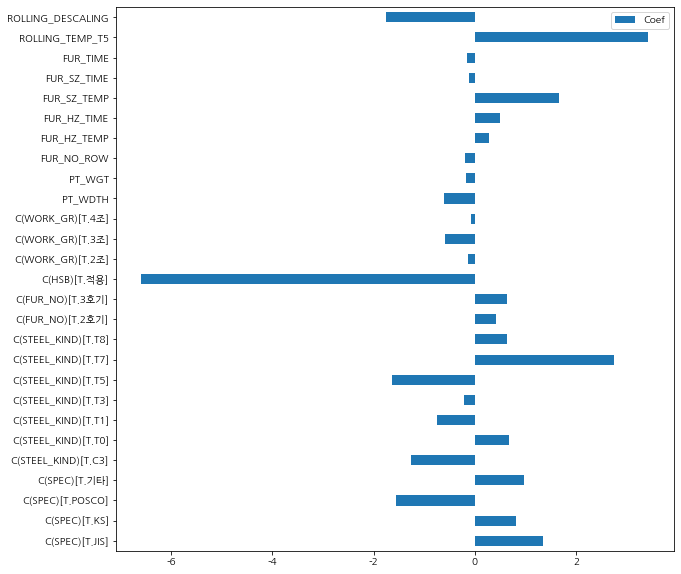

In [44]:
scaled_ds_logistic_coef = pd.DataFrame({"Coef":scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
scaled_ds_logistic_coef.plot.barh(y = "Coef", figsize = (10, 10))

- 표준화한 결과 HSB를 적용한다면, 압연온도가 증가한다면, 강종 종류가 T7이 아니라면 혹은 T5이면, 압연 중 디스케일링을 적용하면, 그리고 제품규격이 포스코일 때 불량일 가능성이 낮아진다고 볼 수 있다. 

# SVC

## 데이터 확인

In [45]:
raw_data.head()
df_raw_x = raw_data.drop('SCALE', axis =1, inplace = False)
df_raw_y = raw_data["SCALE"] 

# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_x_dummy = pd.get_dummies(df_raw_x)

In [46]:
df_x_dummy.head()

,PT_WDTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,3707,14180,1,1144,116,1133,59,282,934,8,...,0,1,0,0,0,1,0,1,0,0
1,3707,14180,2,1144,122,1135,53,283,937,8,...,0,1,0,0,0,1,0,1,0,0
2,3619,18130,1,1129,116,1121,55,282,889,8,...,1,0,1,0,0,1,0,0,1,0
3,3619,18130,2,1152,125,1127,68,316,885,8,...,1,0,1,0,0,1,0,0,1,0
4,3098,12430,1,1140,134,1128,48,314,873,8,...,1,0,0,1,0,1,1,0,0,0


In [47]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

## 기본옵션 모델 생성

In [48]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on train set: 0.683
Accuracy on test set: 0.667


## C 규제에 대한 강도 변경

In [49]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 **c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

# C별 정확도 테이블
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.683,0.671
1,0.10,0.683,0.671
2,1.00,0.683,0.667
3,10.00,0.696,0.667


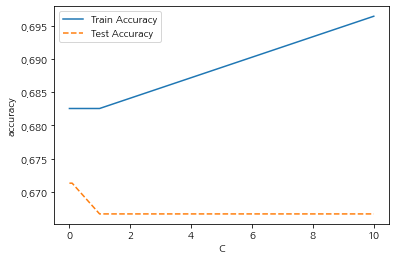

In [50]:
# 정확도를 그래프로 표현
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

- C 값을 테스트 정확도가 가장 높은 0.01로 정하도록 한다

## 감마: 훈련 샘플이 미치는 영향의 범위를 변경

In [51]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 0.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

# Gamma별 정확도 테이블
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.6825,0.6713
1,0.10,0.6825,0.6713
2,1.00,0.6825,0.6713
3,10.00,0.6825,0.6713


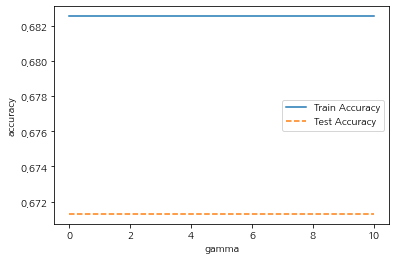

In [52]:
# 정확도를 그래프로 표현
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

- 감마값은 정확도에 영향을 주지 않는다

## 스케일 변환

In [53]:
# 변수명 저장
v_feature_names = df_train_x.columns

# StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x_dummy)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_names)
df_scaled.head()

,PT_WDTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,1.738951,-1.103810,-0.994460,-0.543782,0.767342,-0.949149,-0.626453,-0.409268,0.000734,-0.19693,...,-0.389872,1.414214,-0.700488,-0.713746,-0.219169,0.219169,-0.596601,1.834022,-0.56024,-0.607307
1,1.738951,-1.103810,1.005571,-0.543782,0.932981,-0.835252,-0.856618,-0.387221,0.028567,-0.19693,...,-0.389872,1.414214,-0.700488,-0.713746,-0.219169,0.219169,-0.596601,1.834022,-0.56024,-0.607307
2,1.568896,-0.944112,-0.994460,-1.263141,0.767342,-1.632537,-0.779897,-0.409268,-0.416748,-0.19693,...,2.564946,-0.707107,1.427577,-0.713746,-0.219169,0.219169,-0.596601,-0.545250,1.78495,-0.607307
3,1.568896,-0.944112,1.005571,-0.160124,1.015800,-1.290843,-0.281206,0.340311,-0.453858,-0.19693,...,2.564946,-0.707107,1.427577,-0.713746,-0.219169,0.219169,-0.596601,-0.545250,1.78495,-0.607307
4,0.562094,-1.174562,-0.994460,-0.735611,1.264257,-1.233894,-1.048422,0.296219,-0.565186,-0.19693,...,2.564946,-0.707107,-0.700488,1.401058,-0.219169,0.219169,1.676163,-0.545250,-0.56024,-0.607307


In [54]:
# 데이터 분할
df_train_x, df_test_x = train_test_split(df_scaled, test_size = 0.3,random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_test_x.shape))

train data X size : (504, 32)
train data Y size : (216, 32)


## 스케일링 후 SVC 모델 재실행

In [55]:
svm_scaled = SVC(random_state=1234)
svm_scaled.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(svm_scaled.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(svm_scaled.score(df_test_x, df_test_y)))

Accuracy on training set: 0.913
Accuracy on test set: 0.833


In [56]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 ** c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

# C별 정확도 테이블 
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.683,0.671
1,0.10,0.696,0.694
2,1.00,0.913,0.833
3,10.00,0.976,0.833


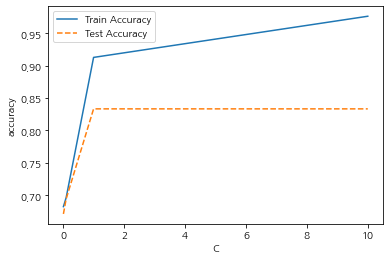

In [57]:
# 정확도를 그래프로 표현
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

- c값을 1로 정하도록 한다(과적합 방지)

In [58]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

# Gamma별 정확도 테이블 
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.883,0.870
1,0.10,0.962,0.829
2,1.00,0.998,0.676
3,10.00,1.000,0.671


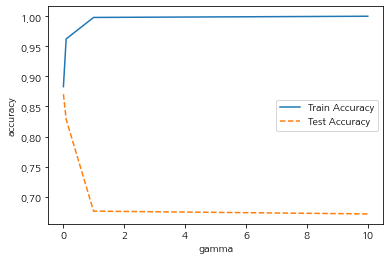

In [59]:
# Gamma별 정확도 그래프로 확인
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

- 감마는 가장 작았던 0.01 값에서 최고의 정확도를 보여준다

## 결론 도출

In [60]:
# 최종 모델
svc_final = SVC(gamma = 0.01, C = 1, random_state = 1234)
svc_final.fit(df_train_x, df_train_y)

# 평가
y_pred = svc_final.predict(df_test_x)
svc_train_acc=svc_final.score(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(svc_train_acc))
svc_test_acc=svc_final.score(df_test_x, df_test_y)
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(svc_test_acc))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accucary on training set: 0.883
Accuracy on test set: 0.870

Confusion matrix: 
[[134  11]
 [ 17  54]]


In [61]:
estimator = SVC(random_state = 1234)

# 구하고자 하는 parameter와 범위
param_grid = {"C": para_c,
              "gamma": para_gamma}

# 정확도가 높은 최적 parameter 찾기
grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
grid_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest parameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=10, gamma=0.01, random_state=1234)

best parameter: 
{'C': 10, 'gamma': 0.01}

best score: 
0.873


In [62]:
svc_f1_score = f1_score(df_test_y, y_pred)
print("F1 score: {:.3f}".format(scaled_log_f1_score))

F1 score: 0.787


In [63]:
# 추가해주기
final_train_accuracy.append(svc_train_acc)
final_test_accuracy.append(svc_test_acc)
final_model_f1_score.append(svc_f1_score)

In [64]:
final_model_f1_score

[0.7866666666666666, 0.7941176470588235]

# 의사결정트리

In [65]:
from sklearn.tree import DecisionTreeClassifier
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accucary on training set: 1.000
Accucary on test set: 0.977


In [66]:
from sklearn.tree import DecisionTreeClassifier
# 만약 그래프비즈가 안되면...
from sklearn.tree import plot_tree

## 맥스 뎁스: 최대 깊이 변경

In [67]:
para_depth = [depth for depth in range(1, 11)]
para_depth

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [68]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = max_depth, random_state = 1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.929,0.944
2,3,0.958,0.972
3,4,0.966,0.977
4,5,0.968,0.977
5,6,0.972,0.977
6,7,0.972,0.977
7,8,0.976,0.977
8,9,0.982,0.981
9,10,0.984,0.977


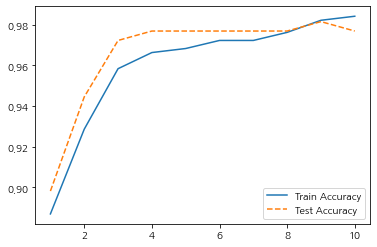

In [69]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [70]:
max_depth=4

## 잎사귀 노드의 샘플 수 변경

In [71]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)


,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.958,0.972
1,20,0.944,0.963
2,30,0.897,0.903
3,40,0.887,0.898
4,50,0.887,0.898
5,60,0.887,0.898
6,70,0.887,0.898
7,80,0.887,0.898
8,90,0.887,0.898
9,100,0.887,0.898


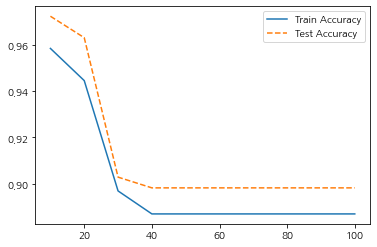

In [72]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [73]:
min_leaf=30

## 최소 스플릿

In [74]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 20 for n_split in range(1, 11)]

for min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split, min_samples_leaf = min_leaf, max_depth =max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.897,0.903
1,40,0.897,0.903
2,60,0.897,0.903
3,80,0.897,0.903
4,100,0.897,0.903
5,120,0.897,0.903
6,140,0.897,0.903
7,160,0.897,0.903
8,180,0.897,0.903
9,200,0.897,0.903


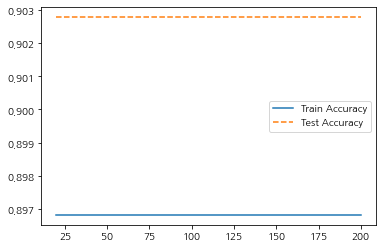

In [75]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

- min split은 값을 지정해주지 않아도 변화가 없다

## 최종 모델 선정, 시각화


In [76]:
tree_final = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_leaf)
tree_final.fit(df_train_x, df_train_y)
# 평가
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.903

Confusion matrix: 
[[138   7]
 [ 14  57]]


In [77]:
# 추가해주기
tree_f1_score = f1_score(df_test_y, y_pred)
tree_test_score=tree_final.score(df_test_x, df_test_y)
tree_train_score=tree_final.score(df_train_x, df_train_y)
final_train_accuracy.append(tree_train_score)
final_test_accuracy.append(tree_test_score)
final_model_f1_score.append(tree_f1_score)

## 결론

In [78]:
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.870
5,FUR_SZ_TEMP,0.100
3,FUR_HZ_TEMP,0.027
4,FUR_HZ_TIME,0.004
0,PT_WDTH,0.000
25,FUR_NO_3호기,0.000
20,STEEL_KIND_T5,0.000
21,STEEL_KIND_T7,0.000
22,STEEL_KIND_T8,0.000
23,FUR_NO_1호기,0.000


Text(0, 0.5, '설명변수')

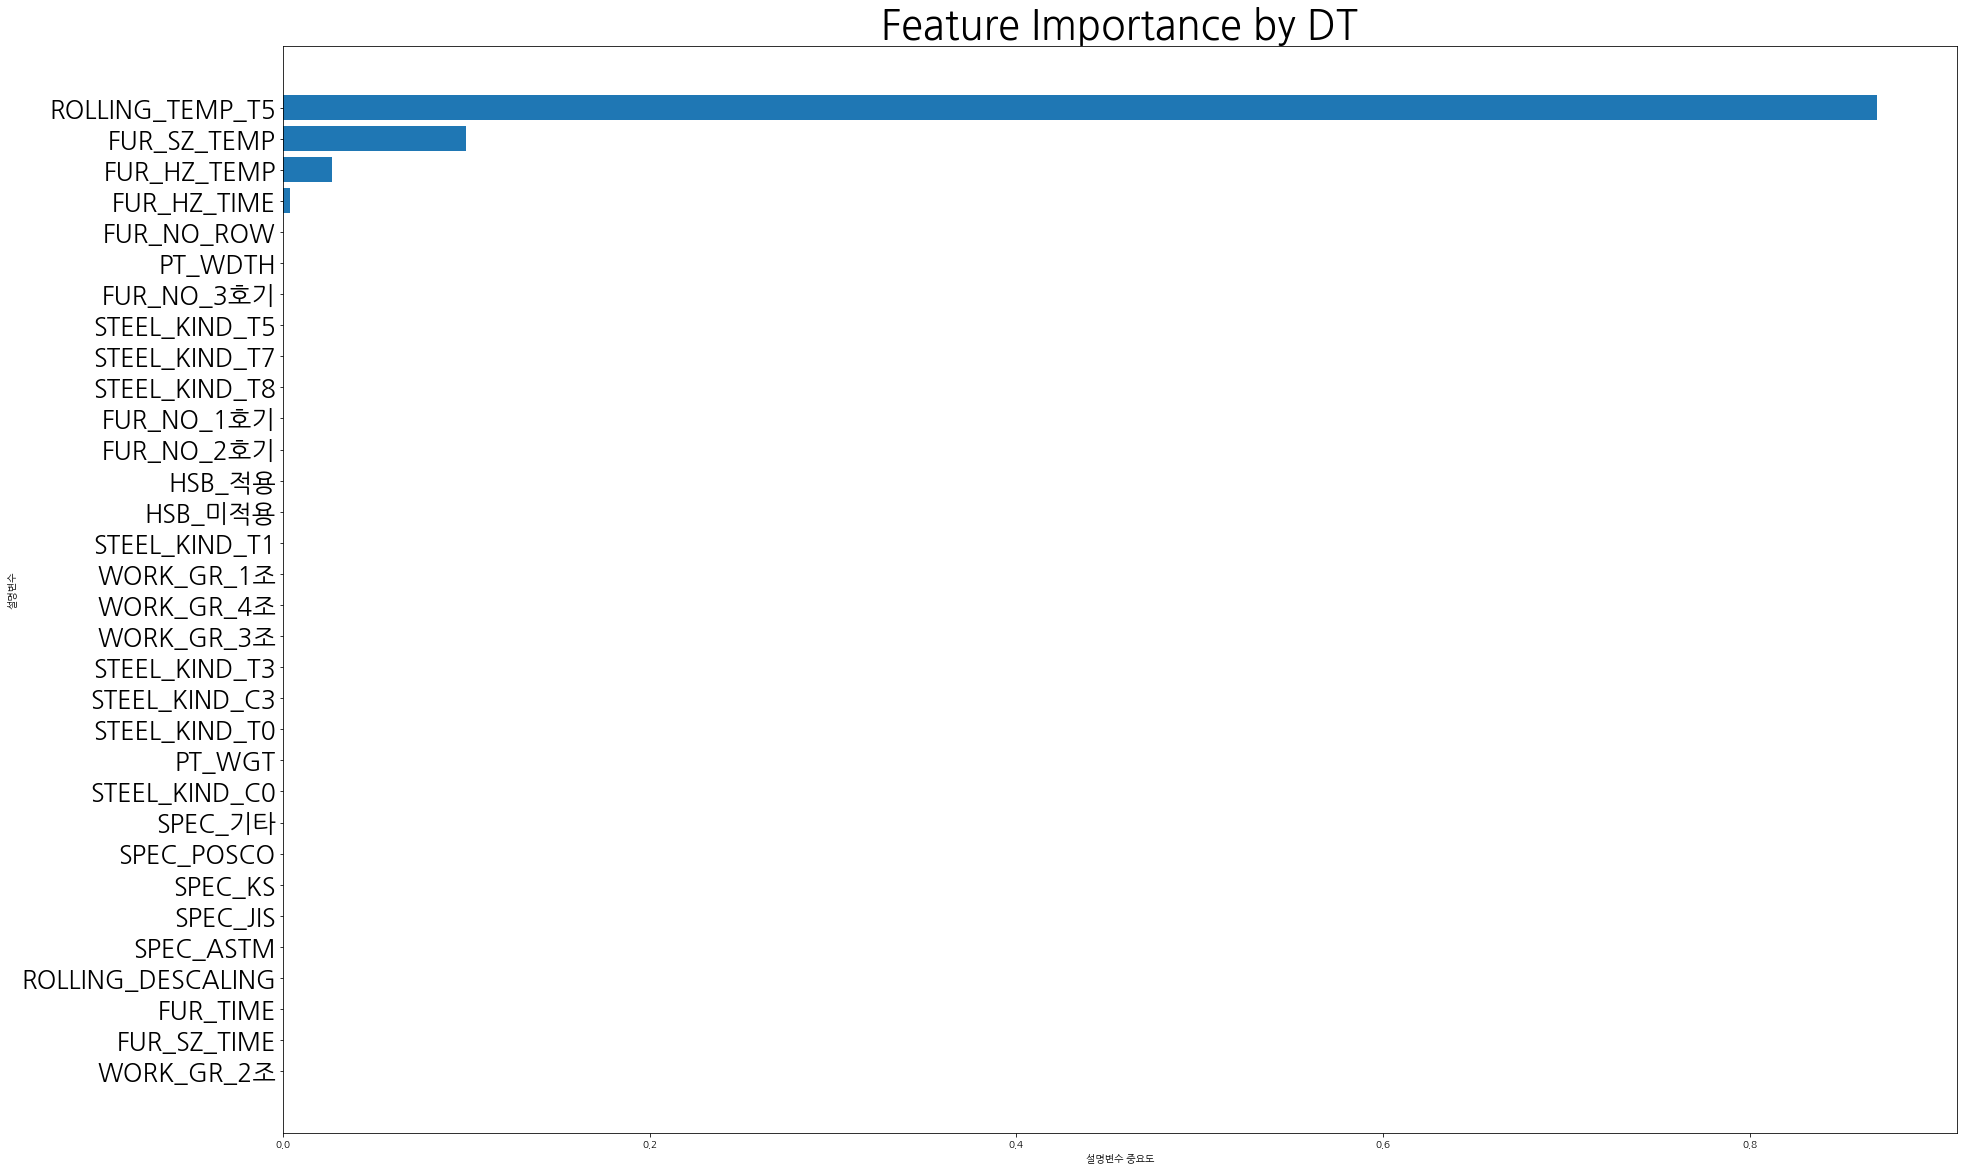

In [79]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
plt.figure(figsize=(30, 20))
plt.title("Feature Importance by DT", fontsize=40)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"], fontsize=25)
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


- 중요도 높은 변수: ROLLING_TEMP_T5, FUR_SZ_TEMP, FUR_HZ_TEMP

In [80]:
print(final_train_accuracy)
print(final_test_accuracy)
print(final_model_f1_score)

[0.8869047619047619, 0.8829365079365079, 0.8968253968253969]
[0.8518518518518519, 0.8703703703703703, 0.9027777777777778]
[0.7866666666666666, 0.7941176470588235, 0.8444444444444446]


# 랜덤포레스트

In [81]:

from sklearn.ensemble import RandomForestClassifier
####모델 생성(기본 옵션) 및 파라미터 조정
rf_tree_uncustom=RandomForestClassifier(random_state=1234)
rf_tree_uncustom.fit(df_train_x, df_train_y)
print("Score on training set: {}".format(rf_tree_uncustom.score(df_train_x, df_train_y)))
print("Score on testing set: {}".format(rf_tree_uncustom.score(df_test_x, df_test_y)))


Score on training set: 1.0
Score on testing set: 0.9722222222222222


## 트리 개수 조절

   n_estimators  TrainScore  TestScore
0            10       0.996      0.954
1            20       1.000      0.968
2            30       1.000      0.972
3            40       1.000      0.968
4            50       1.000      0.968
5            60       1.000      0.972
6            70       1.000      0.972
7            80       1.000      0.972
8            90       1.000      0.972
9           100       1.000      0.972


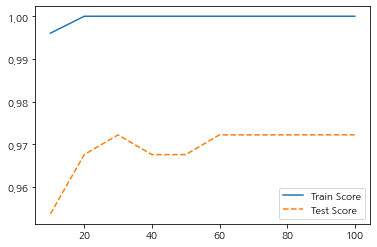

In [82]:
# 트리 수 변경에 따른 모델 성능
train_score=[]; test_score=[]
para_tree=[n_tree* 10 for n_tree in range(1,11)]

for v_n_estimator in para_tree:
    rf=RandomForestClassifier(n_estimators=v_n_estimator, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_tree=pd.DataFrame()
df_score_tree['n_estimators']=para_tree
df_score_tree['TrainScore']=train_score
df_score_tree['TestScore']=test_score
print(df_score_tree.round(3))

# 그래프로 확인
plt.plot(para_tree, train_score, linestyle='-', label="Train Score")
plt.plot(para_tree, test_score, linestyle='--', label="Test Score")
plt.legend()

- 트리수를 10개로 정한다

In [83]:
tree_number=10

## 리프 노트의 수를 늘려가기

    MinSamplesLeaf  TrainScore  TestScore
0                1       0.996      0.954
1                2       0.982      0.958
2                3       0.966      0.954
3                4       0.966      0.958
4                5       0.952      0.944
5                6       0.948      0.935
6                7       0.950      0.907
7                8       0.944      0.907
8                9       0.948      0.898
9               10       0.929      0.898
10              11       0.917      0.903
11              12       0.905      0.907
12              13       0.907      0.898
13              14       0.901      0.903
14              15       0.893      0.894
15              16       0.887      0.898
16              17       0.885      0.884
17              18       0.883      0.889
18              19       0.887      0.894


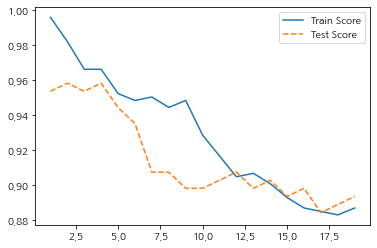

In [84]:
# 잎사귀노드의 수를 늘려가면서 트리를 생성하고 설명력을 기록한다
train_score=[]; test_score=[]
para_leaf=[n_leaf* 1 for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf:
    tree=RandomForestClassifier(random_state=1234,n_estimators=tree_number, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf=pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score
print(df_score_leaf.round(3))

# 그래프로 확인한 모델 설명력
plt.plot(para_leaf, train_score, linestyle='-', label="Train Score")
plt.plot(para_leaf, test_score, linestyle='--', label="Test Score")
plt.legend()

- 리프수를 4로 제한한다

In [85]:
leaf=4

## 스플릿 수 변경

    MinSamplesSplit  TrainScore  TestScore
0                 2         1.0      0.972
1                 3         1.0      0.972
2                 4         1.0      0.972
3                 5         1.0      0.972
4                 6         1.0      0.972
5                 7         1.0      0.972
6                 8         1.0      0.972
7                 9         1.0      0.972
8                10         1.0      0.972
9                11         1.0      0.972
10               12         1.0      0.972
11               13         1.0      0.972
12               14         1.0      0.972
13               15         1.0      0.972
14               16         1.0      0.972
15               17         1.0      0.972
16               18         1.0      0.972
17               19         1.0      0.972
18               20         1.0      0.972


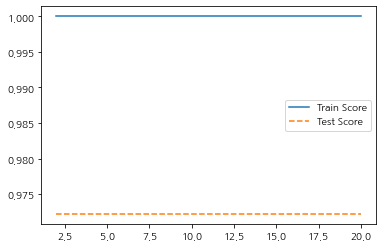

In [86]:
# 분리 노드의 최소 자료 수 변경에 따른 모델 성능
train_score=[]
test_score=[]
para_split=[n_split for n_split in range(2,21)]

for v_min_samples_split in para_split:
    f=RandomForestClassifier(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, min_samples_split=v_min_samples_split)
                            
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

    
df_score_split=pd.DataFrame()
df_score_split['MinSamplesSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score
print(df_score_split.round(3))

plt.plot(para_split, train_score, linestyle='-', label="Train Score")
plt.plot(para_split, test_score, linestyle='--', label="Test Score")
plt.legend()

- 스플릿수는 성능에 영향을 주지 않는다

## 뎁스를 변경

   MinSamplesDepth  TrainScore  TestScore
0                1       0.875      0.889
1                2       0.919      0.912
2                3       0.927      0.907
3                4       0.944      0.949
4                5       0.946      0.935
5                6       0.958      0.944
6                7       0.956      0.940
7                8       0.958      0.949
8                9       0.954      0.963


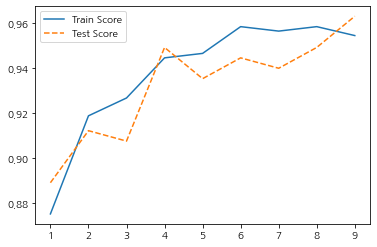

In [87]:
train_score=[]
test_score=[]
para_depth=[n_depth for n_depth in range(1, 10)]

for v_max_samples_depth in para_depth:
    rf=RandomForestClassifier(random_state=1234, n_estimators=tree_number, min_samples_leaf=leaf, max_depth=v_max_samples_depth)
                            
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

    
df_score=pd.DataFrame()
df_score['MinSamplesDepth']=para_depth
df_score['TrainScore']=train_score
df_score['TestScore']=test_score
print(df_score.round(3))



plt.plot(para_depth, train_score, linestyle='-', label="Train Score")
plt.plot(para_depth, test_score, linestyle='--', label="Test Score")
plt.legend()

- 적당한 max_depth 4를 고른다

In [88]:
max_depth=4

## 최종모델

In [89]:
rf_final=RandomForestClassifier(random_state=1234,n_estimators=tree_number, min_samples_leaf=leaf,max_depth=max_depth)
rf_final.fit(df_train_x, df_train_y)

rf_train_score=rf_final.score(df_train_x, df_train_y)
rf_test_score=rf_final.score(df_test_x, df_test_y)
y_pred=rf_final.predict(df_test_x)
rf_tree_f1_score = f1_score(df_test_y, y_pred)
print('\n\n\n*****Customed Model*****')
print('score on training set:{:.3f}'.format(rf_train_score))
print('score on test set:{:.3f}'.format(rf_test_score))






*****Customed Model*****
score on training set:0.944
score on test set:0.949


In [90]:
v_feature_name=df_test_x.columns
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3).head()

,Feature,Importance
8,ROLLING_TEMP_T5,0.371
9,ROLLING_DESCALING,0.107
5,FUR_SZ_TEMP,0.097
26,HSB_미적용,0.096
0,PT_WDTH,0.060


Text(0, 0.5, '변수')

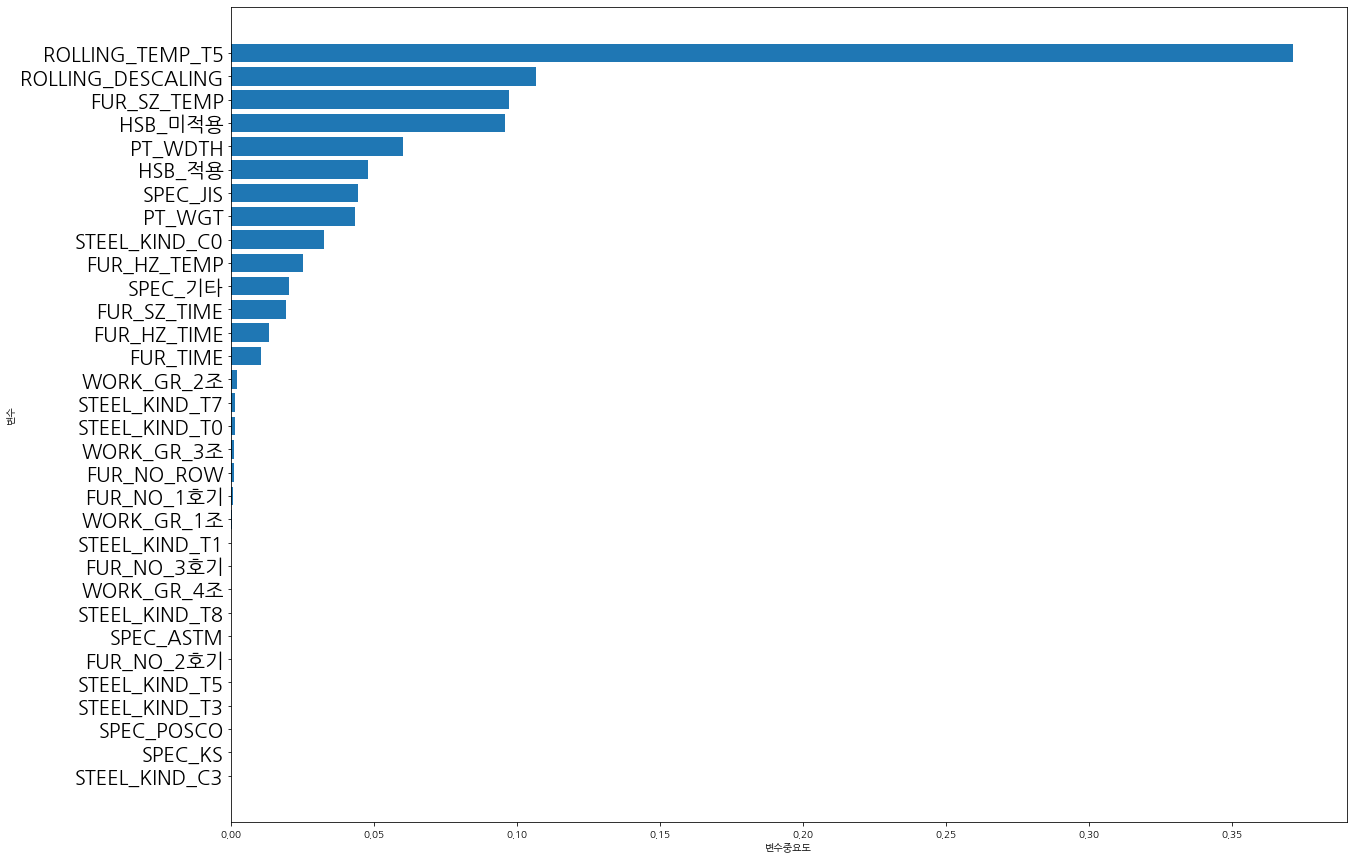

In [91]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize = (20, 15))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'], fontsize=20)
plt.xlabel("변수중요도")
plt.ylabel("변수")

In [92]:
final_train_accuracy.append(rf_train_score)
final_test_accuracy.append(rf_test_score)
final_model_f1_score.append(rf_tree_f1_score)

# 그래디언트 부스팅
## 데이터 적재

In [93]:
raw_data

,SCALE,SPEC,STEEL_KIND,PT_WDTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,ASTM,T1,3707,14180,1호기,1,1144,116,1133,59,282,934,적용,8,2조
1,0,ASTM,T1,3707,14180,1호기,2,1144,122,1135,53,283,937,적용,8,2조
2,0,기타,T8,3619,18130,2호기,1,1129,116,1121,55,282,889,적용,8,3조
3,0,기타,T8,3619,18130,2호기,2,1152,125,1127,68,316,885,적용,8,3조
4,0,기타,T8,3098,12430,3호기,1,1140,134,1128,48,314,873,적용,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,JIS,C0,3580,21870,3호기,1,1172,72,1164,62,245,1005,적용,8,2조
716,0,기타,C0,3212,18340,2호기,1,1150,61,1169,61,238,947,적용,10,1조
717,0,기타,C0,3441,19590,2호기,2,1169,65,1163,77,247,948,적용,10,4조
718,0,기타,C0,3363,80240,3호기,2,1179,86,1163,45,243,940,적용,10,2조


In [94]:
df_raw_x = raw_data.drop("SCALE", axis =1, inplace = False)
df_raw_y = raw_data["SCALE"] 

# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_x_dummy = pd.get_dummies(df_raw_x)
print(df_x_dummy)
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

     PT_WDTH  PT_WGT  FUR_NO_ROW  FUR_HZ_TEMP  FUR_HZ_TIME  FUR_SZ_TEMP  \
0       3707   14180           1         1144          116         1133   
1       3707   14180           2         1144          122         1135   
2       3619   18130           1         1129          116         1121   
3       3619   18130           2         1152          125         1127   
4       3098   12430           1         1140          134         1128   
..       ...     ...         ...          ...          ...          ...   
715     3580   21870           1         1172           72         1164   
716     3212   18340           1         1150           61         1169   
717     3441   19590           2         1169           65         1163   
718     3363   80240           2         1179           86         1163   
719     3400   69840           1         1186           82         1169   

     FUR_SZ_TIME  FUR_TIME  ROLLING_TEMP_T5  ROLLING_DESCALING  ...  \
0             59       282  

## 기본 그래디언트 부스팅 모델 생성

In [95]:

from sklearn.ensemble import GradientBoostingClassifier
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on train set: {:.8f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.8f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Accuracy on train set: 1.00000000
Accuracy on test set: 1.00000000


- 트레인데이터와 테스트 데이터 모두에 과적합인 모습

## 트리 개수 변경

In [96]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도 테이블
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.958,0.972
1,20,0.966,0.977
2,30,0.974,0.977
3,40,0.990,0.986
4,50,0.996,0.991
5,60,1.000,0.991
6,70,1.000,1.000
7,80,1.000,1.000
8,90,1.000,1.000
9,100,1.000,1.000


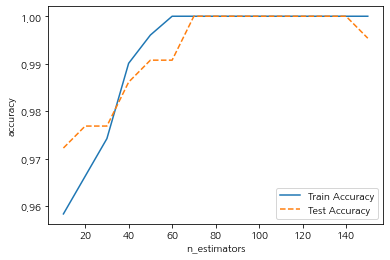

In [97]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

## 러닝 레이트 변경

In [98]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경: 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, n_estimators = 10, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도 테이블
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,0.958,0.972
1,0.2,0.966,0.977
2,0.3,0.982,0.981
3,0.4,0.986,0.977
4,0.5,0.996,0.977
5,0.6,1.000,0.995
6,0.7,1.000,0.977
7,0.8,1.000,0.981
8,0.9,1.000,1.000


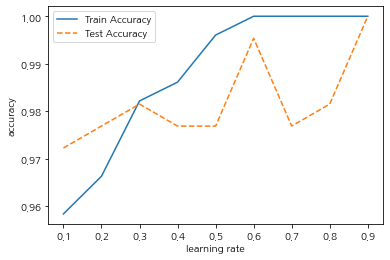

In [99]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

- 0.1로 러닝레이트 정리
## 맥스뎁스를 정하기

In [100]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                                    n_estimators = 10, learning_rate = 0.1,random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# max_depth별 정확도 테이블
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.929,0.944
2,3,0.958,0.972
3,4,0.966,0.977
4,5,0.966,0.977
5,6,0.972,0.977
6,7,0.978,0.977
7,8,0.994,0.986
8,9,0.998,0.991
9,10,0.994,0.991


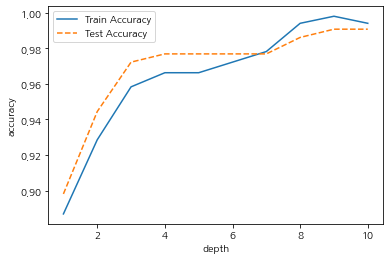

In [101]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

- 뎁스는 5로 정한다

## 잎사귀 정하기

In [102]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth = 5, n_estimators = 10, learning_rate = 0.1, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도 테이블
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.980,0.991
1,20,0.952,0.968
2,30,0.891,0.898
3,40,0.887,0.898
4,50,0.887,0.898
5,60,0.887,0.898
6,70,0.887,0.898
7,80,0.887,0.898
8,90,0.887,0.898
9,100,0.887,0.898


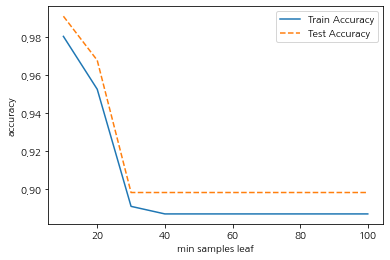

In [103]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

- 최소 잎사귀 노드 수는 10개로 정한다

## 최소 샘플 스플릿 조정

In [104]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, min_samples_leaf = 10,
                                    max_depth = 5,n_estimators = 10, learning_rate = 0.3, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도 테이블
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.990,0.995
1,30,0.988,0.991
2,40,0.988,0.991
3,50,0.988,0.991
4,60,0.988,0.991
5,70,0.992,0.995
6,80,0.992,0.995
7,90,0.990,0.991
8,100,0.992,0.995


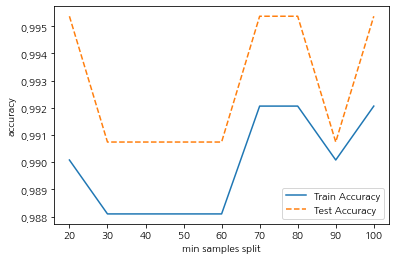

In [105]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

## 결론도출
### 최종 모델 선택

In [106]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf = 10, max_depth = 5, n_estimators = 10,
                                      learning_rate = 0.1, random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)
gb_train_score=gb_final.score(df_train_x, df_train_y)
gb_test_score=gb_final.score(df_test_x, df_test_y)
gb_f1_score = f1_score(df_test_y, y_pred)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_train_score))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_test_score))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.980
Accuracy on test set: 0.991

Confusion matrix: 
[[145   0]
 [  2  69]]


### 설명변수 중요도

In [107]:
# 변수명
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.614
26,HSB_미적용,0.135
5,FUR_SZ_TEMP,0.129
9,ROLLING_DESCALING,0.089
27,HSB_적용,0.030
31,WORK_GR_4조,0.001
0,PT_WDTH,0.001
17,STEEL_KIND_T0,0.001
1,PT_WGT,0.000
7,FUR_TIME,0.000


Text(0, 0.5, '설명변수')

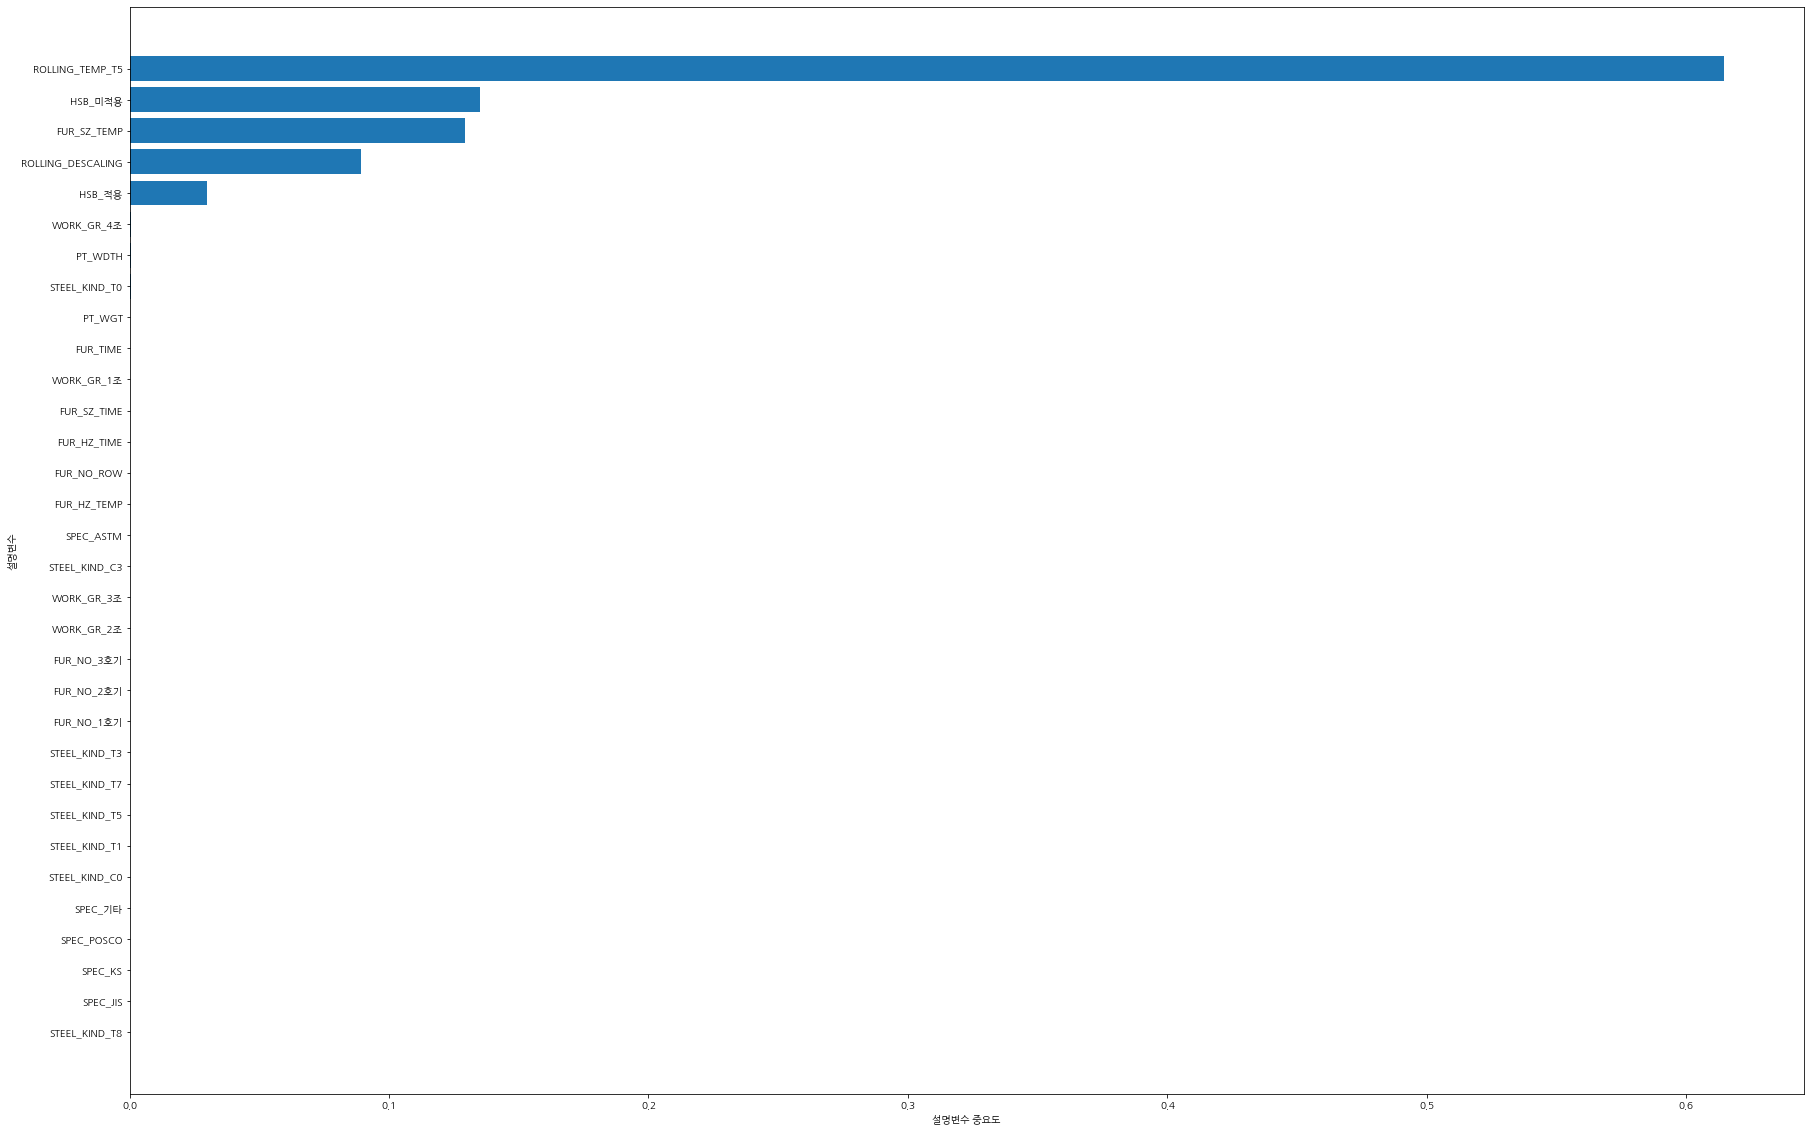

In [108]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
plt.figure(figsize=(30, 20))
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


In [109]:
final_train_accuracy.append(gb_train_score)
final_test_accuracy.append(gb_test_score)
final_model_f1_score.append(gb_f1_score)

# Catboost

In [110]:
from catboost import CatBoostClassifier
import time
start=time.time()
X = raw_data.drop('SCALE', axis =1, inplace = False)
y = raw_data["SCALE"] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234)
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    eval_metric="Accuracy",
    loss_function='MultiClass'
)

cat_features=["FUR_NO", "STEEL_KIND", "SPEC", "FUR_NO_ROW", 'HSB', 'WORK_GR']

clf.fit(X_train, y_train, 
        eval_set=(X_val, y_val), 
        verbose=False,
        plot=True,
        cat_features=cat_features
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [111]:
print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'MultiClass', 'eval_metric': 'Accuracy'}


In [112]:
y_pred=clf.predict(X_val)

In [113]:
print("Catboost F1Score: {}".format(f1_score(y_val, y_pred)))

Catboost F1Score: 0.900763358778626


In [114]:
cat_train_acc=clf.score(X_train, y_train)
cat_tset_acc=accuracy_score(y_val, y_pred)
print("Catboost Train 정확도 : {}".format(cat_train_acc))
print("Catboost test 정확도 : {}".format(cat_tset_acc))

Catboost Train 정확도 : 0.9246031746031746
Catboost test 정확도 : 0.9398148148148148


In [115]:
# 추가해주기
final_train_accuracy.append(cat_train_acc)
final_test_accuracy.append(cat_tset_acc)
final_model_f1_score.append(f1_score(y_val, y_pred))

In [116]:
cat_importance=pd.DataFrame({'feature_importance': clf.get_feature_importance(), 
              'feature_names': X_val.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

<BarContainer object of 15 artists>

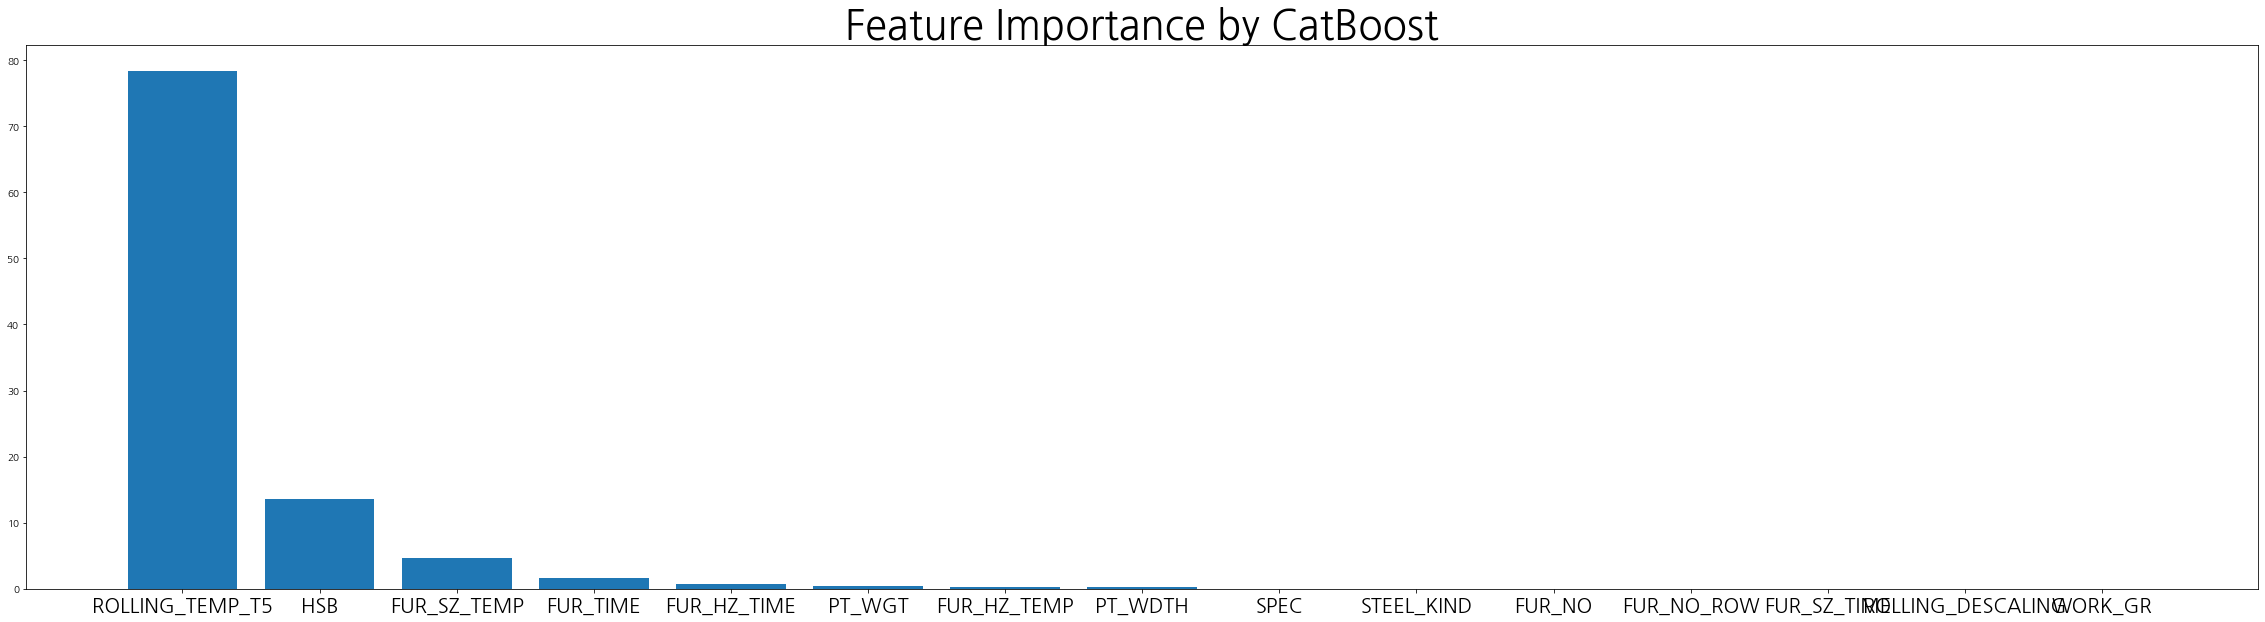

In [126]:
plt.figure(figsize=(40, 10))
plt.title("Feature Importance by CatBoost", fontsize=40)
plt.xticks(fontsize=20)
plt.bar(cat_importance.feature_names, cat_importance.feature_importance)

In [118]:
cat_importance

,feature_importance,feature_names
11,78.340971,ROLLING_TEMP_T5
12,13.624256,HSB
8,4.638001,FUR_SZ_TEMP
10,1.569522,FUR_TIME
7,0.736090,FUR_HZ_TIME
3,0.459020,PT_WGT
6,0.331473,FUR_HZ_TEMP
2,0.300667,PT_WDTH
0,0.000000,SPEC
1,0.000000,STEEL_KIND


In [119]:
print("***train 정확도(Logistic, SVC, DT, RF, GB, CatBoost 순서)***\n{}".format(final_train_accuracy))
print("***test 정확도 Logistic, SVC, DT, RF, GB, CatBoost 순서***\n{}".format(final_test_accuracy))
print("***F1 score Logistic, SVC, DT, RF, GB, CatBoos***\n{}".format(final_model_f1_score))

***train 정확도(Logistic, SVC, DT, RF, GB, CatBoost 순서)***
[0.8869047619047619, 0.8829365079365079, 0.8968253968253969, 0.9444444444444444, 0.9801587301587301, 0.9246031746031746]
***test 정확도 Logistic, SVC, DT, RF, GB, CatBoost 순서***
[0.8518518518518519, 0.8703703703703703, 0.9027777777777778, 0.9490740740740741, 0.9907407407407407, 0.9398148148148148]
***F1 score Logistic, SVC, DT, RF, GB, CatBoos***
[0.7866666666666666, 0.7941176470588235, 0.8444444444444446, 0.916030534351145, 0.9857142857142858, 0.900763358778626]


# 모델 평가: F1 Score, 정확도 

In [120]:
evalu = pd.DataFrame(index = final_model_acc)
evalu["TrainAccuracy"] = final_train_accuracy
evalu["TestAccuracy"] = final_test_accuracy
evalu["F1Score"] = final_model_f1_score
evalu.round(3)

,TrainAccuracy,TestAccuracy,F1Score
Logistic,0.887,0.852,0.787
SVC,0.883,0.870,0.794
DT,0.897,0.903,0.844
RandomForest,0.944,0.949,0.916
GradientBoosting,0.980,0.991,0.986
Catboost,0.925,0.940,0.901


<AxesSubplot:>

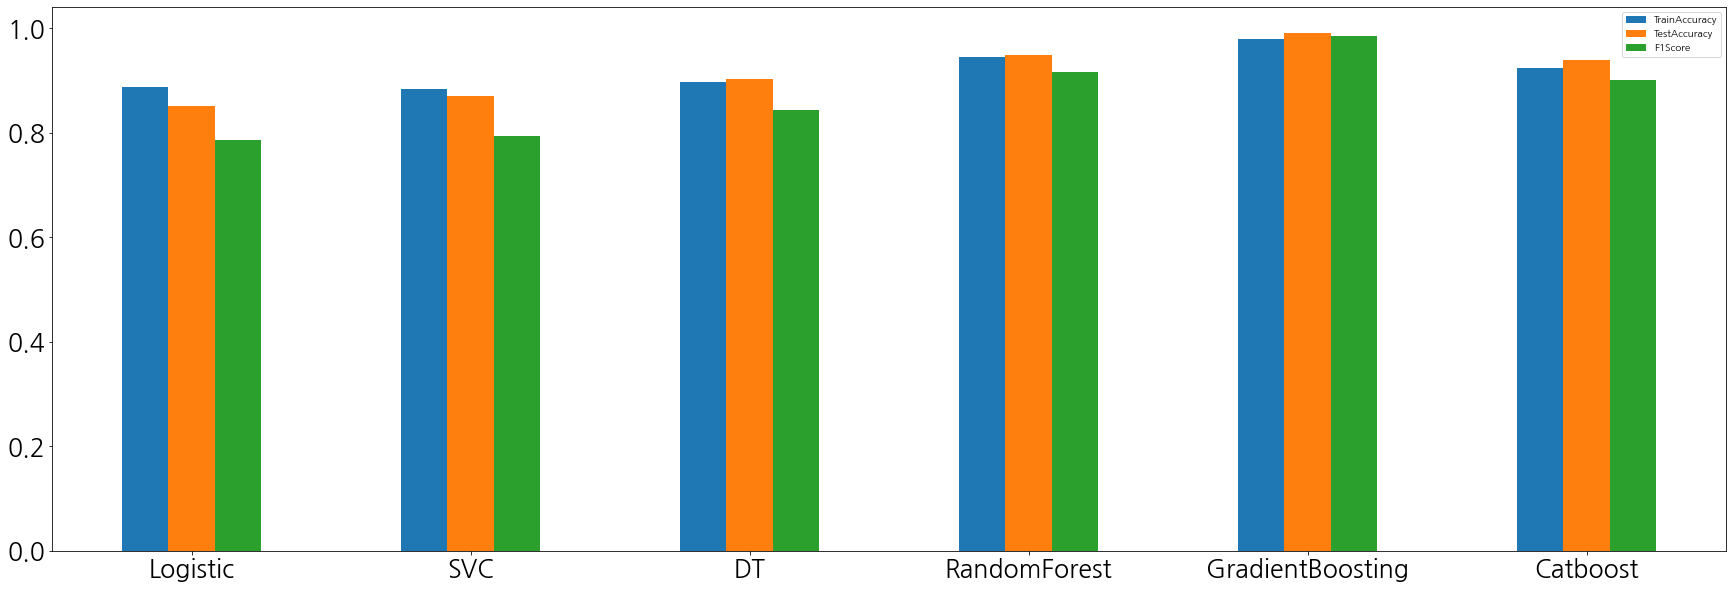

In [121]:
evalu.plot.bar(rot = 0, figsize = (30, 10),fontsize=25  )


- 가장 높은 정확도와 f1 score를 갖는 그래디언트 부스팅으로 선택한다. 해당 모델은 설명변수 중요도
    - ROLLING_TEMP_T5	0.614
    - HSB_미적용	0.135
    - FUR_SZ_TEMP	0.129
    - ROLLING_DESCALING	0.089 로 나왔었고,
- FUR_EXTEMP와 FUR_SZ_TEMP는 0.985의 상관계수를 가지기 때문에, 둘 중 하나인 FUR_EXTEMP를 삭제했었다
- 또한 다른 강한 상관관계인 변수 PT_THK and PT_LTH도 삭제되었다. 
- 따라서 FUR_SZ_TEMP와 상관관계에 있는 FUR_EXTEMP도 주요 인자로 선정될 수 있다.
- ROLLING_DESCALING은 다른 주요인자보다 중요성은 떨어지지만, 해당 인자와 상관관계에 있어 삭제된  PT_THK 와 PT_LTH도 해당 모델의 주요인자로 선정될 수 있겠다. 

- 포스코 특허 번호 10-1428320에서
    - 주요인자: 가열시간(FUR_TIME), 추출온도(FUR_EXTEMP), 디스켈링횟수(ROLLING_DESCALING) 가 있는가?
  
- 디스켈링횟수(ROLLING_ DESCALING)와 추출온도(FUR_EXTEMP)는 주요인자로 해당 모델에서 선정될 수 있었으나가열 시간은 주요인자가 되지 못함을 알 수 있다.

- 로지스틱 예측의 인자들을 보면
> 표준화한 결과 HSB를 적용한다면, 압연온도가 증가한다면, 강종 종류가 T7이 아니라면 혹은 T5이면, 압연 중 디스케일링을 적용하면, 그리고 제품규격이 포스코일 때 불량일 가능성이 낮아진다고 볼 수 있다.

# 최종
> 압연 중 스케일 발생을 줄이기 위한 방법은 다음과 같다. 

- 가열대 온도(ROLLING_TEMP_T5)를 낮추면,
- hsb를 적용(HSB) 적용하면, 낮춰짐
- 추출온도(FUR_EXTEMP)를 낮추기

- 포스코 특허 번호 10-1428320에서 언급한 스케일링 발생 요인

    - 주요인자: 가열시간(FUR_TIME), 추출온도(FUR_EXTEMP), 디스켈링횟수(ROLLING_DESCALING) 가 그래디언트 부스팅 주요인자에 포함되는가?
    - 디스켈링횟수(ROLLING_ DESCALING)와 추출온도(FUR_EXTEMP)는 주요인자로 해당 모델에서 선정될 수 있었으나 가열 시간은 주요인자가 되지 못함을 알 수 있다.